<a href="https://colab.research.google.com/github/hanggao811/AnomalyDetectionLIGO/blob/Transformer/Transformer_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Input
from matplotlib import pyplot as plt
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import glob

import re
# Set random seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
# Mount to googlecolab
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/dataset')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Load data and normalize it
background_train = np.load('background_train.npy')
stds_train = np.std(background_train, axis=-1)[:, :, np.newaxis]
background_train = background_train/stds_train
background_train = np.swapaxes(background_train, 1, 2)
background_test = np.load('background_test.npy')
stds_test = np.std(background_test, axis=-1)[:, :, np.newaxis]
background_test = background_test/stds_test
background_test = np.swapaxes(background_test, 1, 2)

bbh_train = np.load('bbh_train.npy')
stds_train = np.std(bbh_train, axis=-1)[:, :, np.newaxis]
bbh_train = bbh_train/stds_train
bbh_train = np.swapaxes(bbh_train, 1, 2)
bbh_test = np.load('bbh_test.npy')
stds_test = np.std(bbh_test, axis=-1)[:, :, np.newaxis]
bbh_test = bbh_test/stds_test
bbh_test = np.swapaxes(bbh_test, 1, 2)

sglf_train = np.load('sglf_train.npy')
stds_train = np.std(sglf_train, axis=-1)[:, :, np.newaxis]
sglf_train = sglf_train/stds_train
sglf_train = np.swapaxes(sglf_train, 1, 2)
sglf_test = np.load('sglf_test.npy')
stds_test = np.std(sglf_test, axis=-1)[:, :, np.newaxis]
sglf_test = sglf_test/stds_test
sglf_test = np.swapaxes(sglf_test, 1, 2)

In [3]:
# # ----- Background Data -----
# # Load and convert background_train
# background_train_np = np.load('background_train.npy')
# background_train = tf.convert_to_tensor(background_train_np, dtype=tf.float32)
# stds_train = tf.math.reduce_std(background_train, axis=-1, keepdims=True)
# background_train = background_train / stds_train
# # Swap axes: Assuming original shape is (num_samples, axis1, axis2), swap axis1 and axis2.
# background_train = tf.transpose(background_train, perm=[0, 2, 1])

# # Load and convert background_test
# background_test_np = np.load('background_test.npy')
# background_test = tf.convert_to_tensor(background_test_np, dtype=tf.float32)
# stds_test = tf.math.reduce_std(background_test, axis=-1, keepdims=True)
# background_test = background_test / stds_test
# background_test = tf.transpose(background_test, perm=[0, 2, 1])


# # ----- BBH Data -----
# # Load and convert bbh_train
# bbh_train_np = np.load('bbh_train.npy')
# bbh_train = tf.convert_to_tensor(bbh_train_np, dtype=tf.float32)
# stds_train = tf.math.reduce_std(bbh_train, axis=-1, keepdims=True)
# bbh_train = bbh_train / stds_train
# bbh_train = tf.transpose(bbh_train, perm=[0, 2, 1])

# # Load and convert bbh_test
# bbh_test_np = np.load('bbh_test.npy')
# bbh_test = tf.convert_to_tensor(bbh_test_np, dtype=tf.float32)
# stds_test = tf.math.reduce_std(bbh_test, axis=-1, keepdims=True)
# bbh_test = bbh_test / stds_test
# bbh_test = tf.transpose(bbh_test, perm=[0, 2, 1])


# # ----- SGLF Data -----
# # Load and convert sglf_train
# sglf_train_np = np.load('sglf_train.npy')
# sglf_train = tf.convert_to_tensor(sglf_train_np, dtype=tf.float32)
# stds_train = tf.math.reduce_std(sglf_train, axis=-1, keepdims=True)
# sglf_train = sglf_train / stds_train
# sglf_train = tf.transpose(sglf_train, perm=[0, 2, 1])

# # Load and convert sglf_test
# sglf_test_np = np.load('sglf_test.npy')
# sglf_test = tf.convert_to_tensor(sglf_test_np, dtype=tf.float32)
# stds_test = tf.math.reduce_std(sglf_test, axis=-1, keepdims=True)
# sglf_test = sglf_test / stds_test
# sglf_test = tf.transpose(sglf_test, perm=[0, 2, 1])


In [4]:
# Prepare input X
x_train = np.concatenate([background_train, bbh_train, sglf_train], axis=0)
x_test = np.concatenate([background_test, bbh_test, sglf_test], axis=0)

# create target y for classifier
cl_target_train = np.concatenate([
    np.zeros(background_train.shape[:1]+ (1,) ),
    np.ones(bbh_train.shape[:1]+ (1,) ),
    np.ones(sglf_train.shape[:1]+ (1,)  )
], axis=0)

cl_target_test = np.concatenate([
    np.zeros(background_test.shape[:1]+ (1,) ),
    np.ones(bbh_test.shape[:1]+ (1,)),
    np.ones(sglf_test.shape[:1]+ (1,))
], axis=0)

#create target y for autoencoder mask(batch_size,200,3)
ae_target_train = np.concatenate([np.zeros(background_train.shape[:2]+ (1,) ),
    np.ones(bbh_train.shape[:2]+ (1,) ),
    np.ones(sglf_train.shape[:2]+ (1,)  )
], axis=0)

ae_target_test = np.concatenate([
    np.zeros(background_test.shape[:2]+ (1,) ),
    np.ones(bbh_test.shape[:2]+ (1,)),
    np.ones(sglf_test.shape[:2]+ (1,))
], axis=0)

ae_target_train = np.concatenate([x_train,ae_target_train], axis=-1)
ae_target_test = np.concatenate([x_test,ae_target_test], axis=-1)

# Shuffle the data using NumPy
train_indices = np.random.permutation(x_train.shape[0])
x_train = x_train[train_indices]
cl_target_train = cl_target_train[train_indices]
ae_target_train = ae_target_train[train_indices]

test_indices = np.random.permutation(x_test.shape[0])
x_test = x_test[test_indices]
cl_target_test = cl_target_test[test_indices]
ae_target_test = ae_target_test[test_indices]

# split
X_train, X_val, cls_y_train, cls_y_val, ae_y_train, ae_y_val = train_test_split(x_train, cl_target_train ,ae_target_train, test_size=0.2)


# print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
# print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

SOLUTION GIVEN

In [5]:
@tf.keras.utils.register_keras_serializable()
def masked_mse_loss(y_true, y_pred):
        """
        Assumes y_true has shape (..., input_dim + 1), where:
          - The first input_dim elements are the reconstruction target.
          - The last element is the mask: 0 for background, 1 for bbh/sg.
        We invert the mask so that:
          - Background (0) becomes 1 (compute loss).
          - bbh/sg (1) becomes 0 (ignore loss).
        """
        # mask: background becomes 1, others become 0.
        mask = (1 - y_true[..., -1])[...,-1]
        actual_target = y_true[..., :-1]

        mse = tf.reduce_mean(tf.square(actual_target - y_pred), axis=(1,2))
        masked_mse = mse * mask  # only background samples contribute
        sum_mse = tf.reduce_sum(masked_mse)
        count_bg = tf.reduce_sum(mask)
        avg_mse = sum_mse / (count_bg + 1e-8)
        return avg_mse


In [6]:
class TriangularCyclicalLearningRate(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, max_lr, step_size):
        """
        Args:
            initial_lr: Lower bound of the learning rate.
            max_lr: Upper bound of the learning rate.
            step_size: Number of iterations (batches) to go from initial_lr to max_lr.
        """
        super().__init__()
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.step_size = tf.cast(step_size, tf.float32)

    def __call__(self, step):
        # step is the global step (iteration)
        step = tf.cast(step, tf.float32)
        cycle = tf.floor(1 + step / (2 * self.step_size))
        x = tf.abs(step / self.step_size - 2 * cycle + 1)
        # Triangular wave from initial_lr to max_lr
        lr = self.initial_lr + (self.max_lr - self.initial_lr) * tf.maximum(0.0, 1.0 - x)
        return lr

    def get_config(self):
        return {
            "initial_lr": float(self.initial_lr),
            "max_lr": float(self.max_lr),
            "step_size": float(self.step_size), }

initial_lr = 1e-5
max_lr = 2e-4
step_size = 275

clr_schedule = TriangularCyclicalLearningRate(initial_lr, max_lr, step_size)

In [7]:
tf.config.experimental.enable_op_determinism()

class Model:
    def __init__(self):
        super().__init__()

    def positional_encoding(self, inputs):
        embed_size = inputs.shape[-1]
        input_length = inputs.shape[-2]
        assert embed_size % 2 == 0, 'embed_size must be even'
        p, i = np.meshgrid(np.arange(input_length), np.arange(embed_size // 2))
        pos_emb = np.empty((1,input_length, embed_size))
        pos_emb[0,:,::2] = np.sin(p/(10000**(2*i/embed_size))).T
        pos_emb[0,:,1::2] = np.cos(p/(10000**(2*i/embed_size))).T
        self.pos_encoding = tf.constant(pos_emb.astype(np.float32))
        return inputs + self.pos_encoding[:, :input_length, :]

    def encoder(self, inputs, num_heads,key_dim, dropout, ffn_encoder):
        input_shape = inputs.shape[-1]
        skip = inputs

        #MultiheadAttention block
        attn_layer = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = key_dim, dropout = dropout)
        Z = attn_layer(inputs, inputs)
        #Add & Norm
        Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
        skip = Z

        #Feedforward block
        Z = tf.keras.layers.Dense(ffn_encoder, activation = 'relu')(Z)
        Z = tf.keras.layers.Dense(input_shape)(Z)
        Z = tf.keras.layers.Dropout(rate=dropout,seed=42)(Z)
        #Add & Norm
        Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
        return Z

    def decoder(self, decoder_in, encoder_out, num_heads, key_dim, dropout, ffn_decoder):
        shape = decoder_in.shape[-1]
        skip = decoder_in
        #Masked-MultiheadAttention block
        attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)
        Y= attn_layer(decoder_in, decoder_in, use_causal_mask=False)
        #Add & Norm
        Y = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Y, skip]))
        skip = Y

        #CrossAttention block
        attn_layer = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)
        Y = attn_layer(query = Y, key = encoder_out, value= encoder_out)
        #Add & Norm
        Y = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Y, skip]))
        skip = Y

        #Feedforward block
        Y = tf.keras.layers.Dense(ffn_decoder, activation = 'relu')(Y)
        Y = tf.keras.layers.Dense(shape)(Y)
        #Add & Norm
        Y = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Y, skip]))
        return Y

    def build_model(self, input_shape, embed_dim, N_encoder, num_heads,key_dim, dropout, ffn_encoder, ffn_decoder, N_decoder):
        inputs = keras.Input(shape=input_shape)
        inputs_emb = tf.keras.layers.Conv1D(
                     filters=16,       # Your embed_dim or desired hidden size
                     kernel_size=1,
                     padding='same',   # So output seq_len remains 200
                     activation='relu' # Or another activation
                     )(inputs)
        inputs_pos = self.positional_encoding(inputs_emb)
        # Encoder
        x = inputs_pos
        for _ in range(N_encoder):
            x = self.encoder(x, num_heads, key_dim, dropout, ffn_encoder)
        encoder_out = x

        # Classifier branch
        pooled_features = layers.GlobalAveragePooling1D()(encoder_out)
        classifier_output = layers.Dense(1, activation='sigmoid', name = 'classifier_output')(pooled_features)

        # Decoder
        x = inputs_pos
        for _ in range(N_decoder):
            x = self.decoder(x, encoder_out, num_heads, key_dim, dropout, ffn_decoder)

        # Output layer
        transformer_output = layers.Dense(input_shape[-1], name='transformer_output')(x)
        self.ae = keras.Model(inputs,{"classifier_output": classifier_output, "transformer_output":transformer_output})
        self.ae.compile(loss={"classifier_output": 'binary_crossentropy','transformer_output': masked_mse_loss},loss_weights={
        'classifier_output': 5, 'autoencoder_output': 1 },metrics = {'classifier_output':'accuracy'}, optimizer=keras.optimizers.Adam(learning_rate=clr_schedule))


# Example usage:

input_shape = x_train.shape[1:]
embed_dim = 16
N_encoder = 1
num_heads = 1
key_dim = 8
dropout = 0.1
ffn_encoder = 8
ffn_decoder = 32
N_decoder = 1
epochs=70
batch_size=700
filters=4
kernel_size=3


# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    embed_dim = embed_dim,
    N_encoder = N_encoder,
    num_heads = num_heads,
    key_dim = key_dim,
    dropout = dropout,
    ffn_encoder = ffn_encoder,
    ffn_decoder = ffn_decoder,
    N_decoder = N_decoder
)

# x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=42)
# split_index = int(0.8 * x_train.shape[0])
# x_train = x_train[:split_index]
# x_val = x_train[split_index:]

# check performance based on each epoch of training
checkpoint = ModelCheckpoint(
    filepath='/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_{epoch:02d}.keras',  # File path pattern, using the epoch number in the file name
    save_weights_only=False,                # Set to True if you want to save only the weights
    save_freq='epoch',                      # Save at the end of every epoch
    verbose=1
)
# Assuming x_train is your input data
history = autoencoder.ae.fit(
    X_train,
    {"classifier_output": cls_y_train, "transformer_output": ae_y_train},
    validation_data=(
        X_val,
        {"classifier_output": cls_y_val, "transformer_output": ae_y_val}
    ),
    epochs=epochs,
    batch_size=batch_size,
    shuffle=False,
    callbacks=[checkpoint]
)



Epoch 1/70
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - classifier_output_accuracy: 0.6650 - classifier_output_loss: 0.6460 - loss: 10.2778 - transformer_output_loss: 1.9264
Epoch 1: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_01.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - classifier_output_accuracy: 0.6650 - classifier_output_loss: 0.6459 - loss: 10.2591 - transformer_output_loss: 1.9226 - val_classifier_output_accuracy: 0.6693 - val_classifier_output_loss: 0.6392 - val_loss: 3.4908 - val_transformer_output_loss: 0.5703
Epoch 2/70
274/275 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - classifier_output_accuracy: 0.6650 - classifier_output_loss: 0.6420 - loss: 2.8221 - transformer_output_loss: 0.4360
Epoch 2: saving model to /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_02.keras
275/275 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - classifier_output_accuracy: 0.6650 - classifier_output_loss: 0.6420 

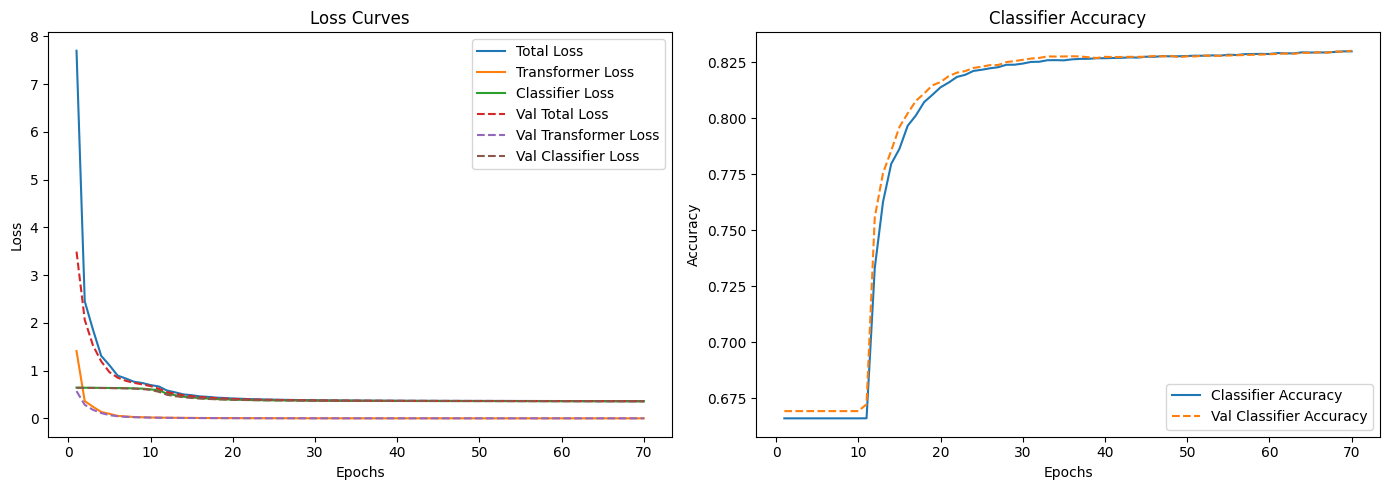

In [8]:
# Extract training history values
loss = history.history['loss']
transformer_loss = history.history['transformer_output_loss']
classifier_loss = history.history['classifier_output_loss']
classifier_accuracy = history.history['classifier_output_accuracy']

# Extract validation history values
val_loss = history.history['val_loss']
val_transformer_loss = history.history['val_transformer_output_loss']
val_classifier_loss = history.history['val_classifier_output_loss']
val_classifier_accuracy = history.history['val_classifier_output_accuracy']

epochs = range(1, len(loss) + 1)

# Plot total loss and individual loss components
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Total Loss')
plt.plot(epochs, transformer_loss, label='Transformer Loss')
plt.plot(epochs, classifier_loss, label='Classifier Loss')
plt.plot(epochs, val_loss, label='Val Total Loss', linestyle='--')
plt.plot(epochs, val_transformer_loss, label='Val Transformer Loss', linestyle='--')
plt.plot(epochs, val_classifier_loss, label='Val Classifier Loss', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot classifier accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, classifier_accuracy, label='Classifier Accuracy')
plt.plot(epochs, val_classifier_accuracy, label='Val Classifier Accuracy', linestyle='--')
plt.title('Classifier Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_01.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


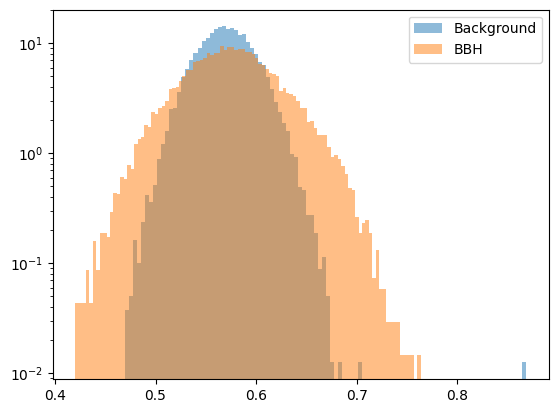

evaluation bg vs sg


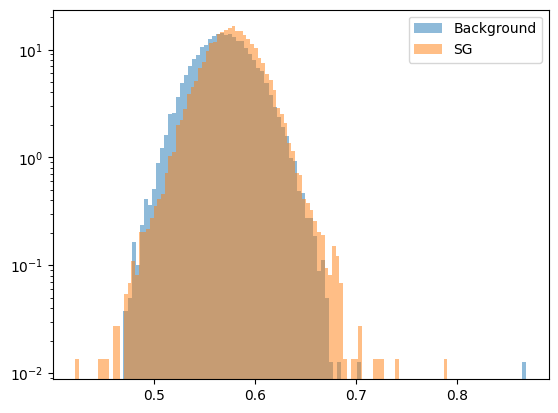

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_02.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


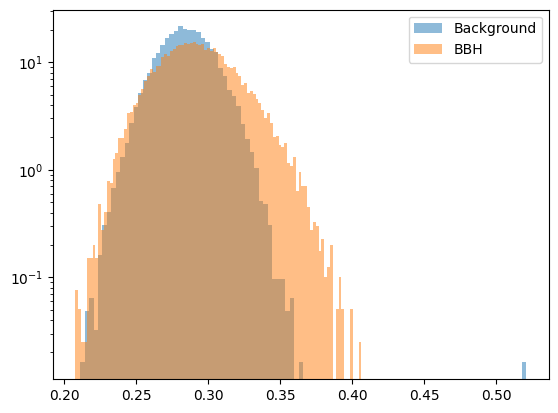

evaluation bg vs sg


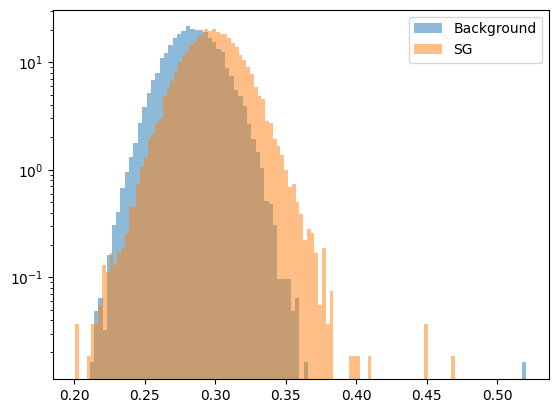

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_03.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


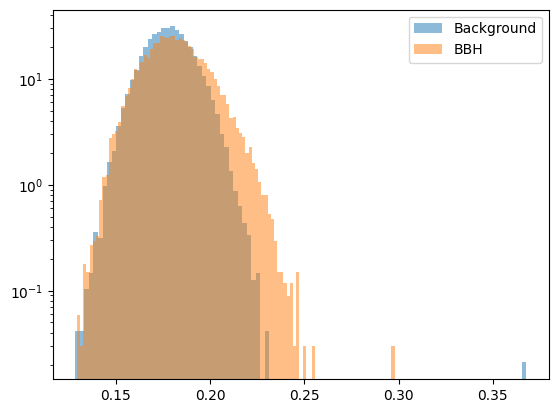

evaluation bg vs sg


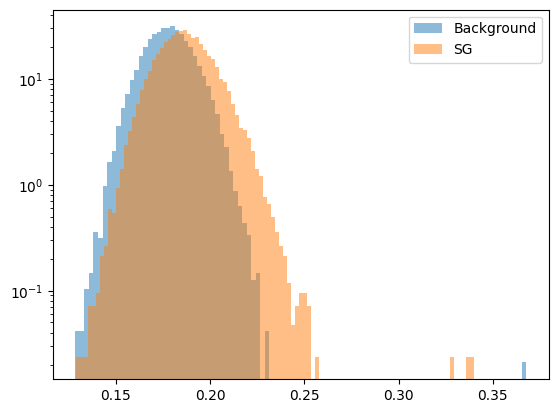

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_04.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


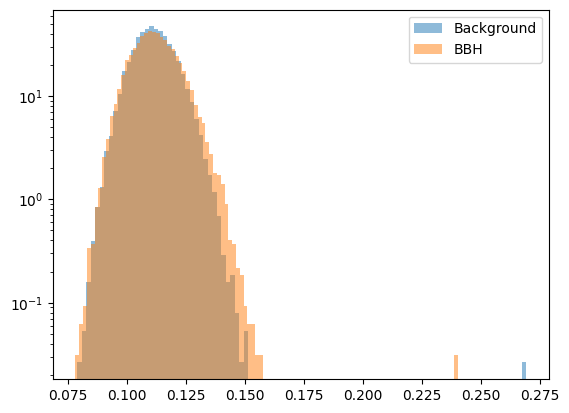

evaluation bg vs sg


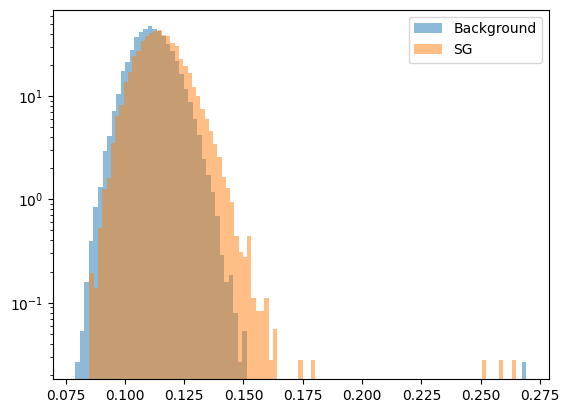

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_05.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


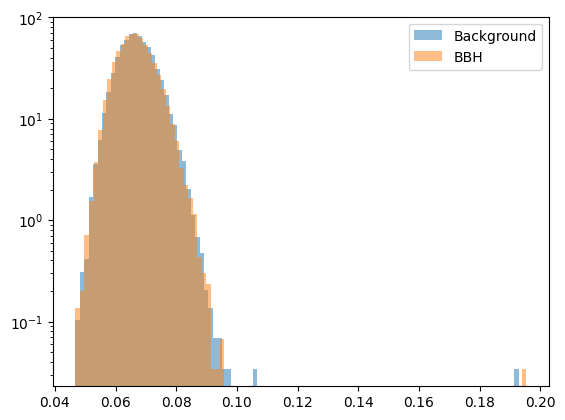

evaluation bg vs sg


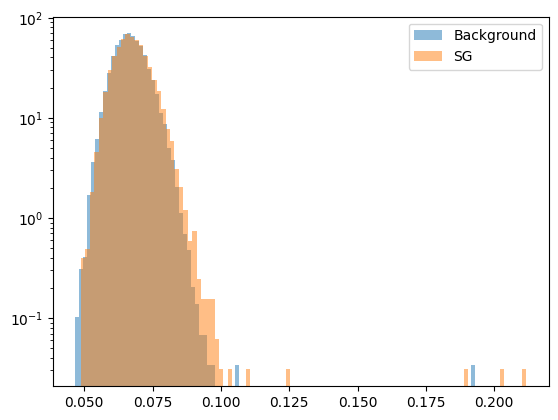

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_06.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


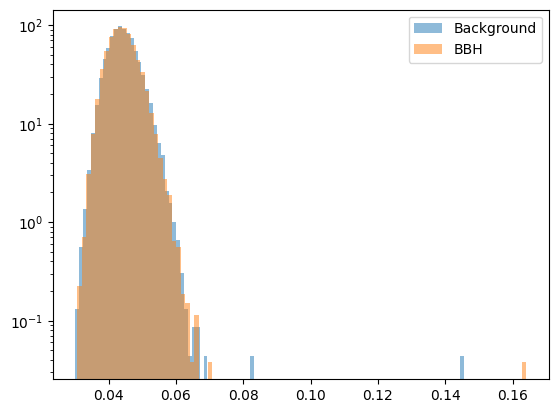

evaluation bg vs sg


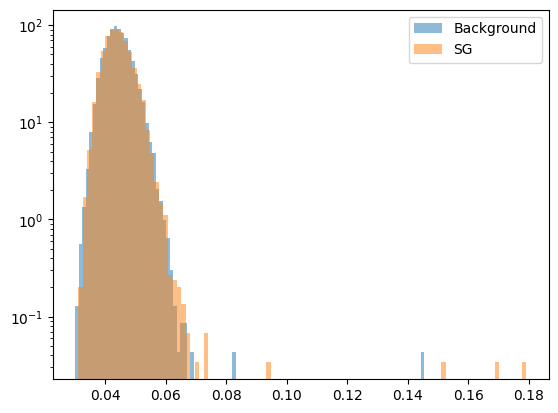

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_07.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


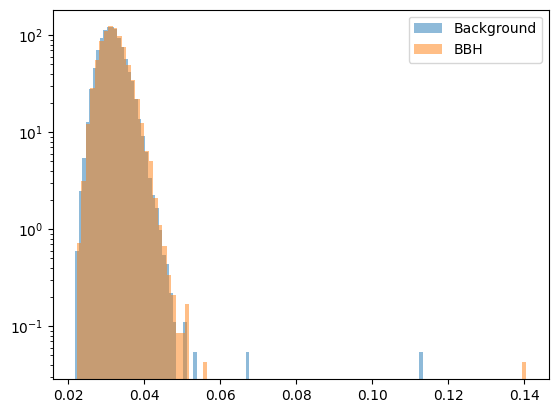

evaluation bg vs sg


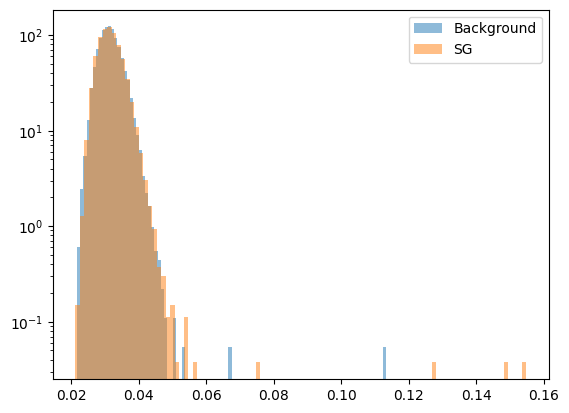

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_08.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


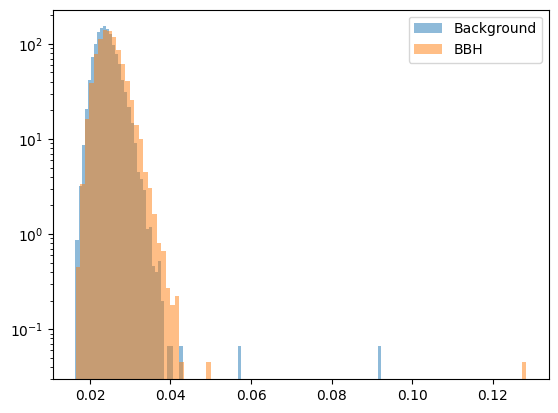

evaluation bg vs sg


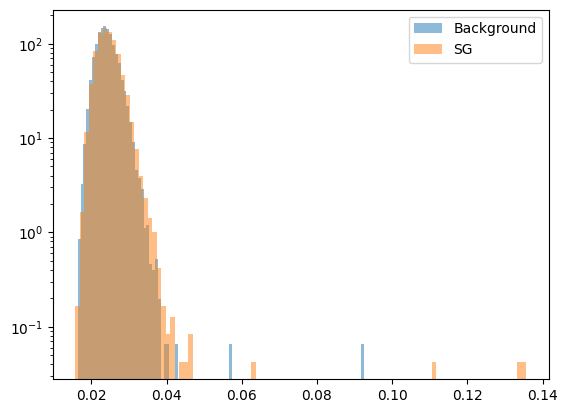

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_09.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


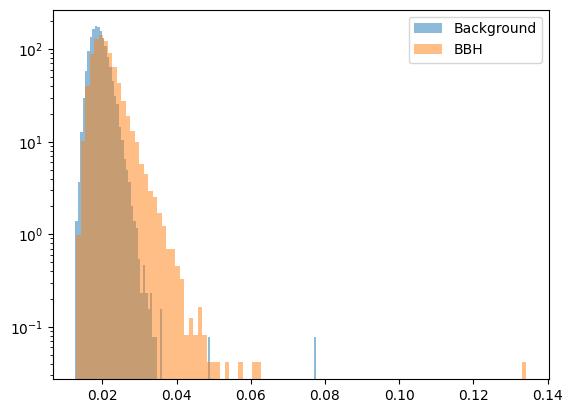

evaluation bg vs sg


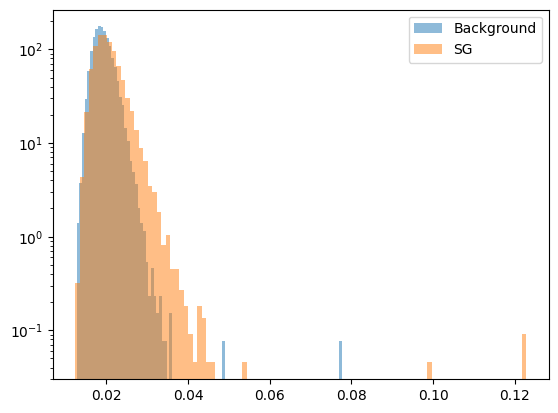

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_10.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


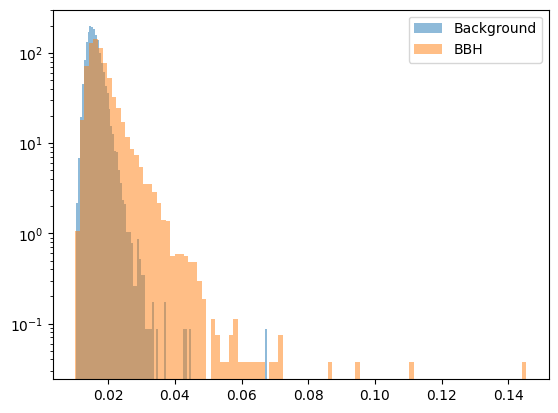

evaluation bg vs sg


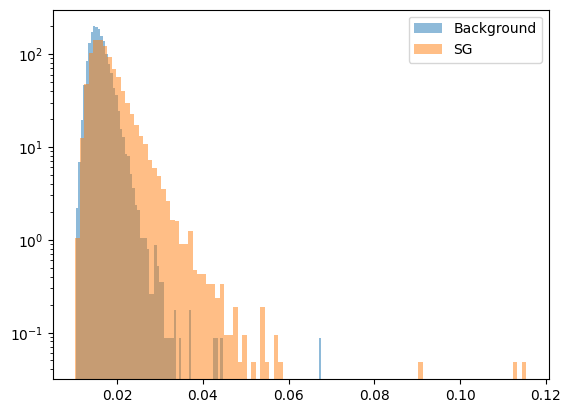

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_11.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


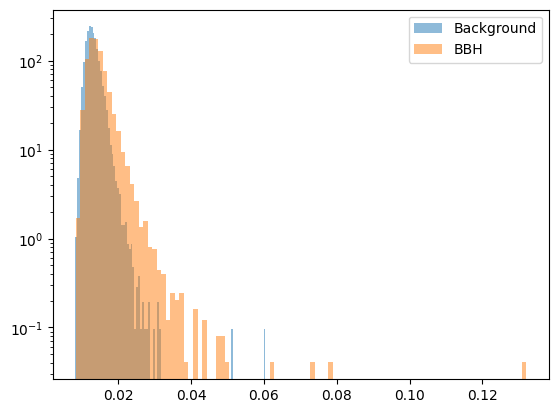

evaluation bg vs sg


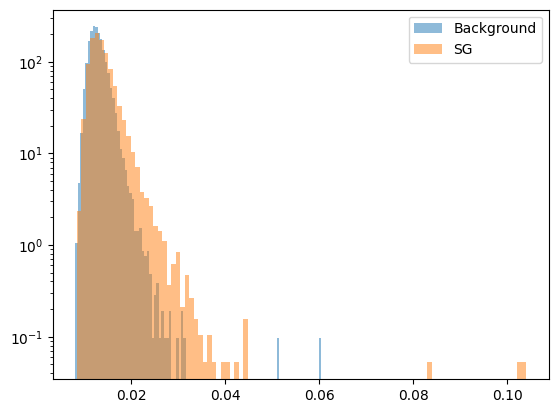

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_12.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


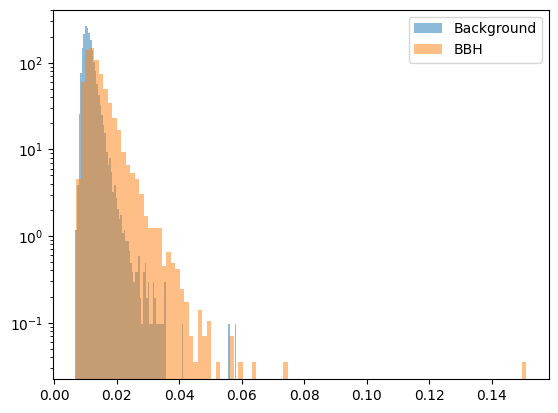

evaluation bg vs sg


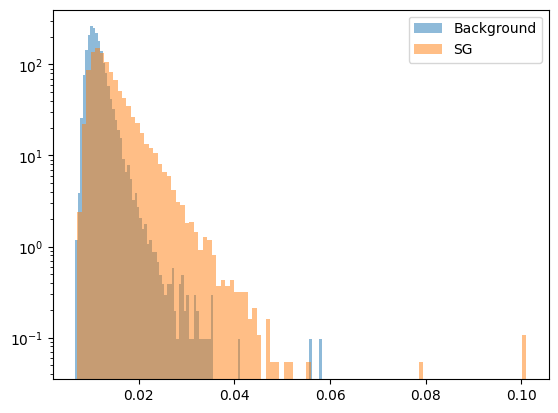

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_13.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


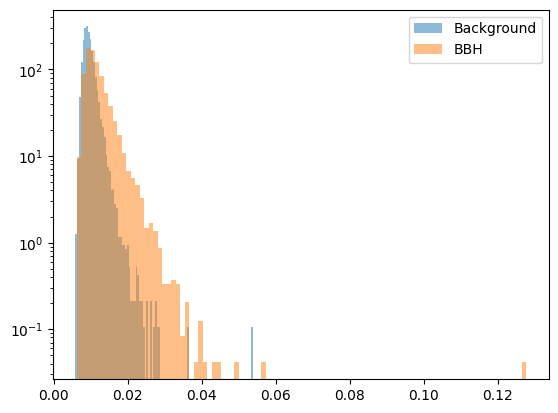

evaluation bg vs sg


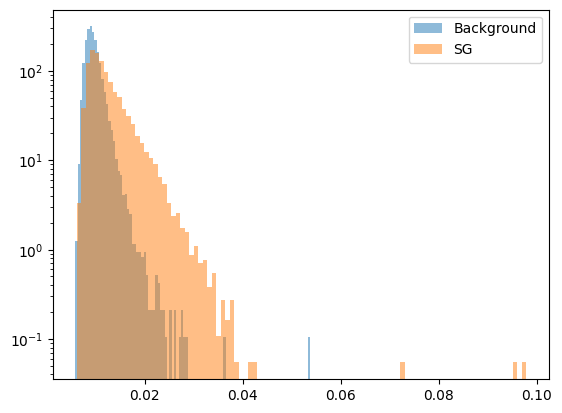

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_14.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


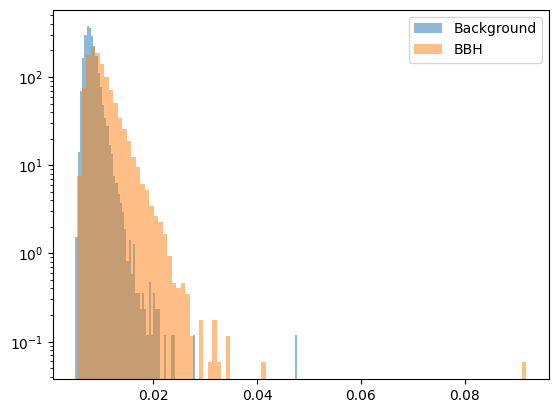

evaluation bg vs sg


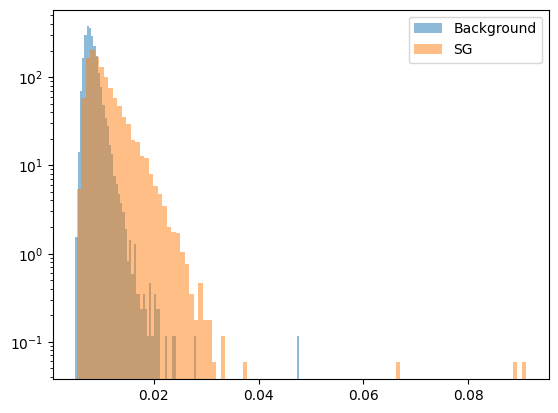

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_15.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


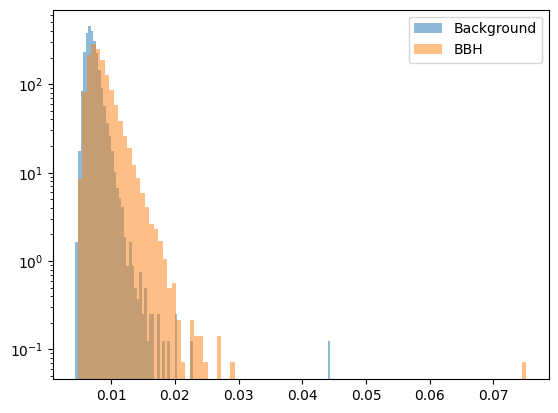

evaluation bg vs sg


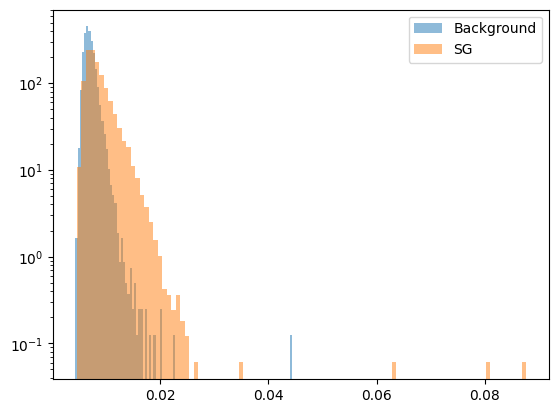

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_16.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


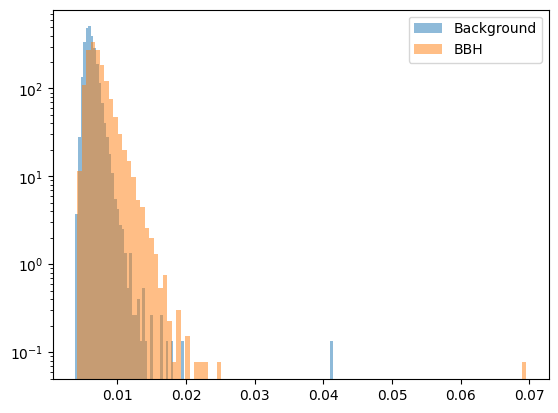

evaluation bg vs sg


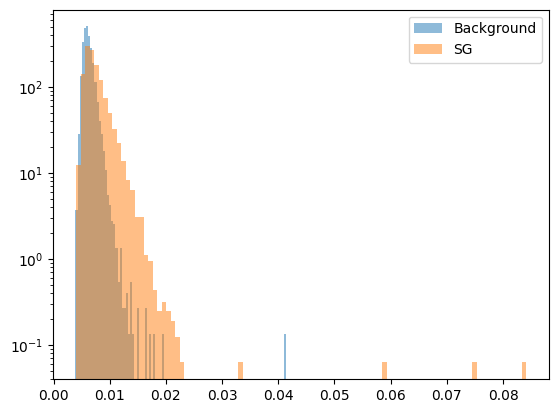

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_17.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


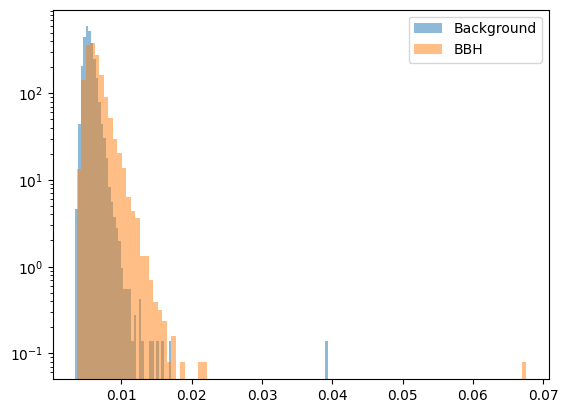

evaluation bg vs sg


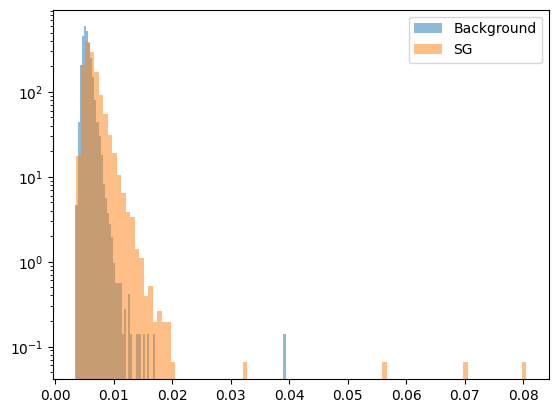

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_18.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


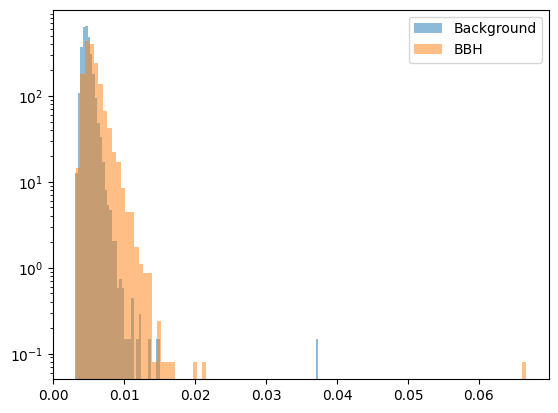

evaluation bg vs sg


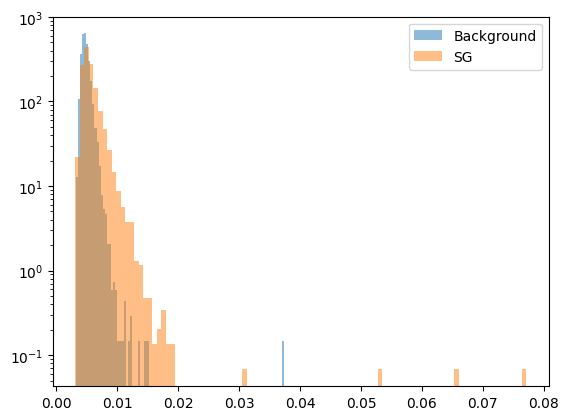

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_19.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


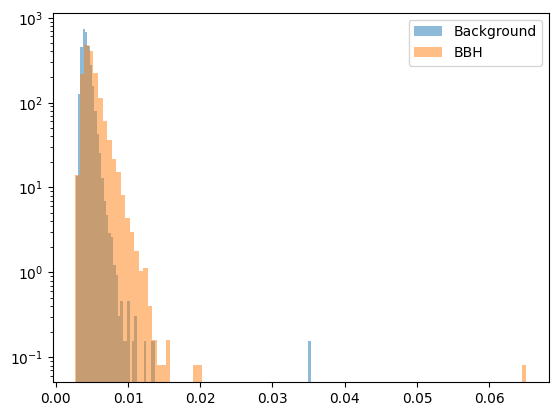

evaluation bg vs sg


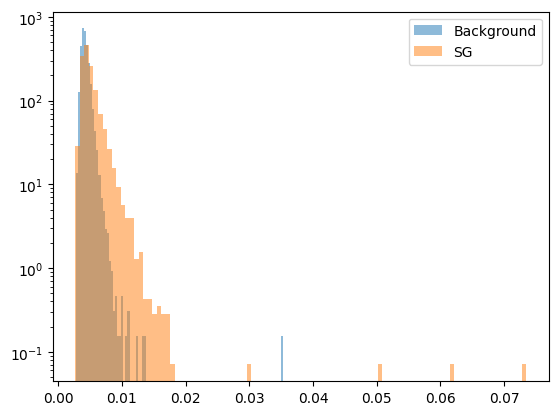

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_20.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


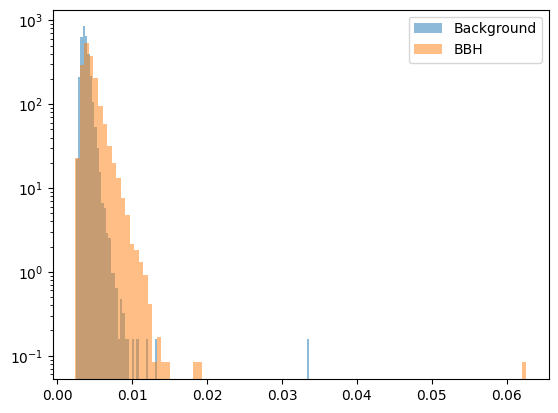

evaluation bg vs sg


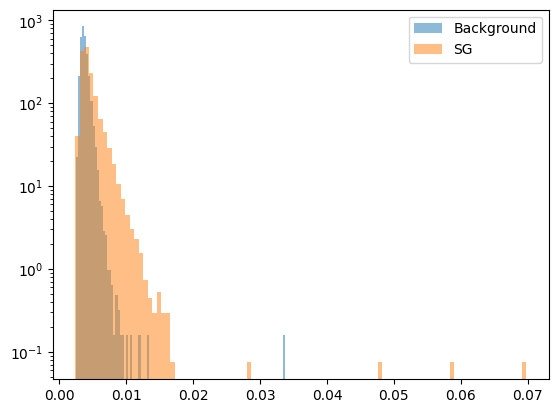

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_21.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


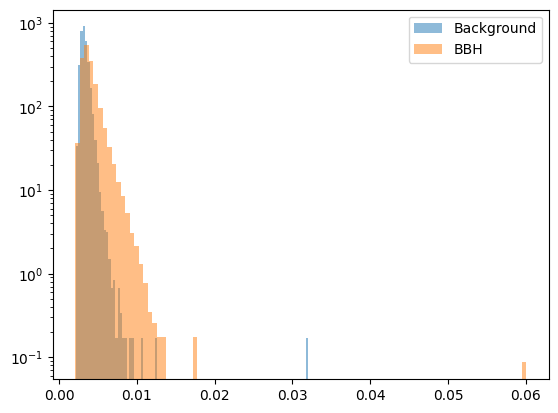

evaluation bg vs sg


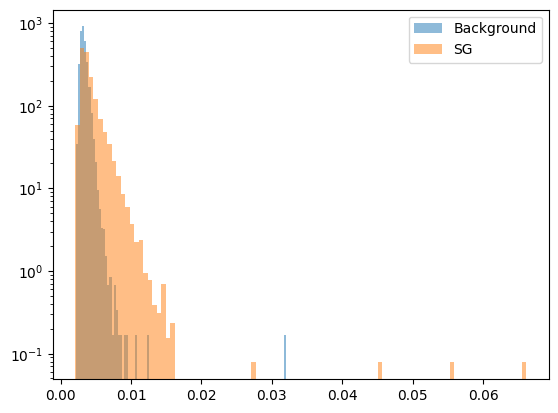

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_22.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


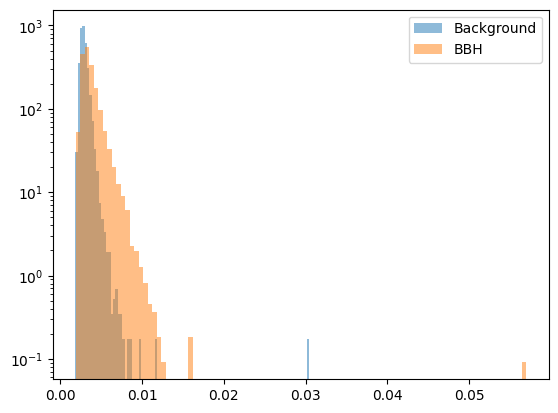

evaluation bg vs sg


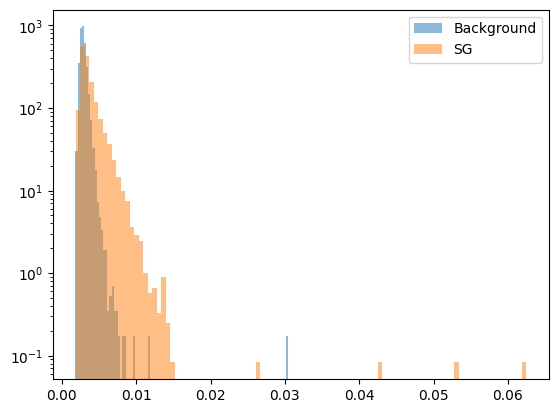

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_23.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


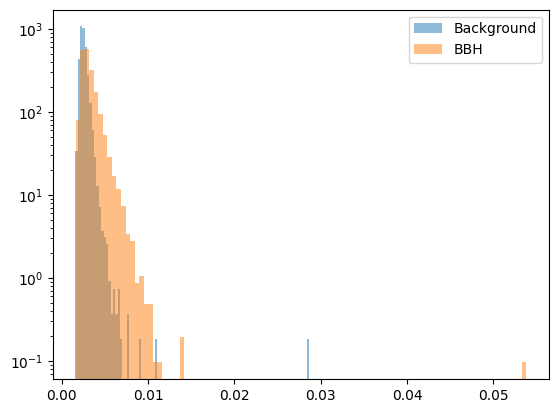

evaluation bg vs sg


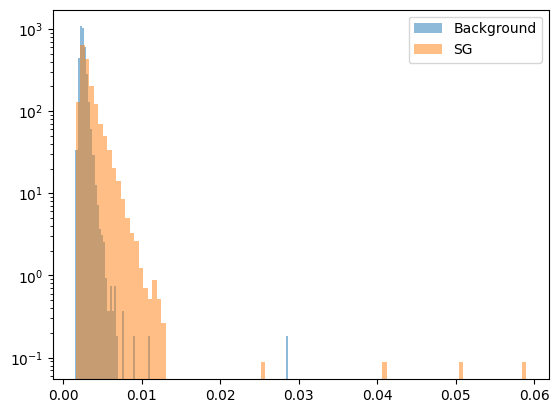

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_24.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


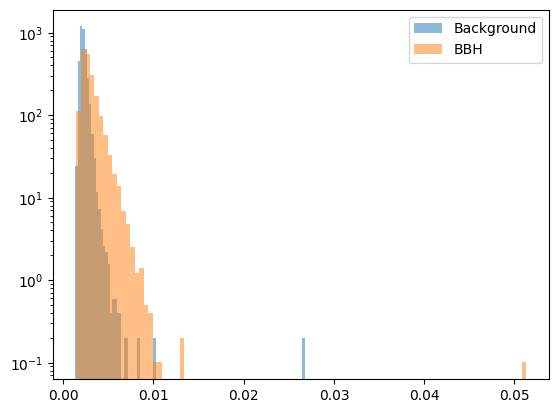

evaluation bg vs sg


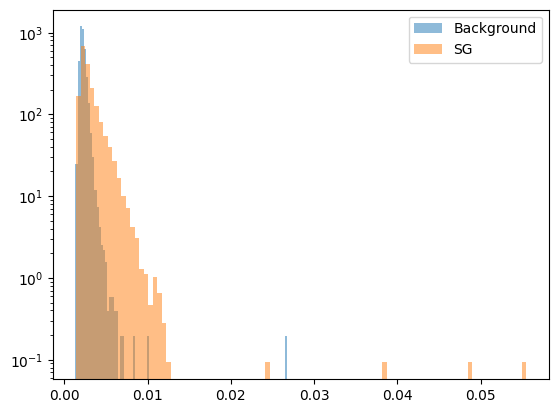

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_25.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


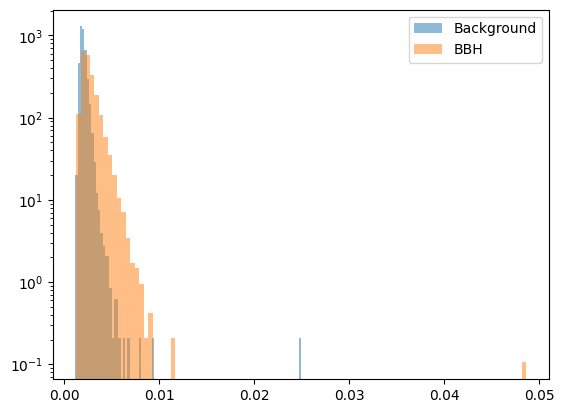

evaluation bg vs sg


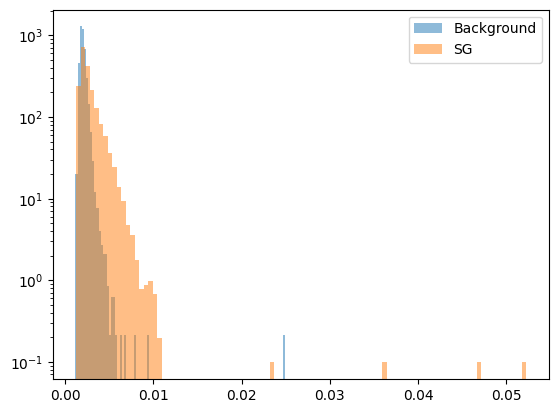

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_26.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


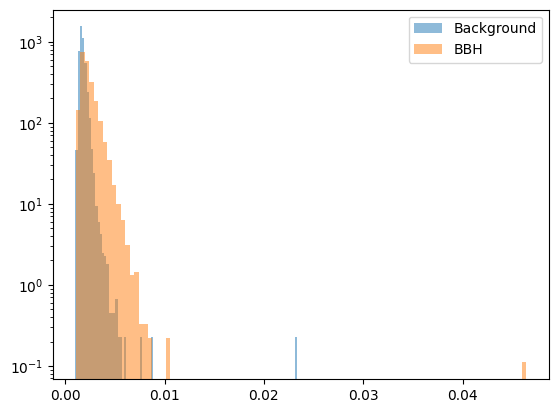

evaluation bg vs sg


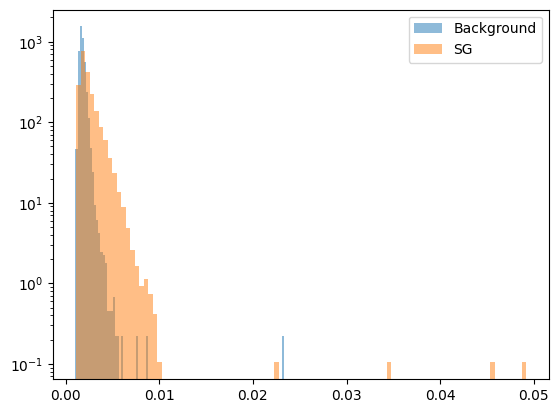

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_27.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


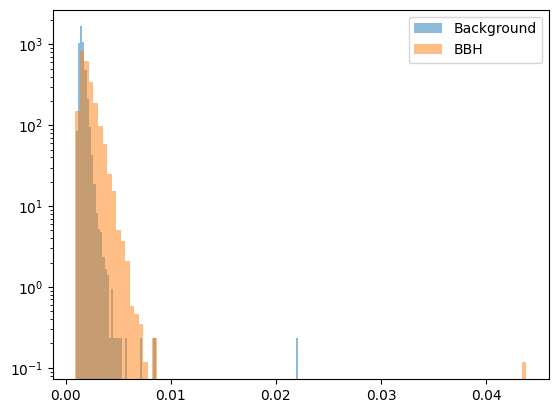

evaluation bg vs sg


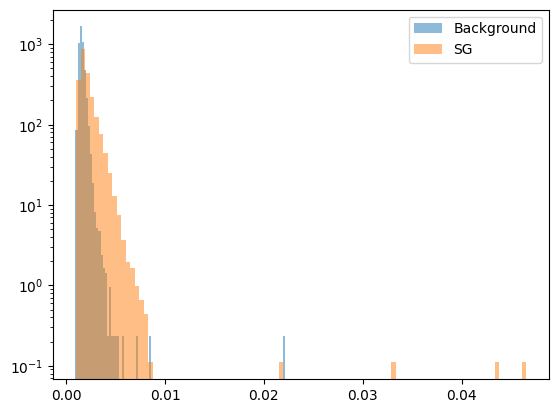

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_28.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


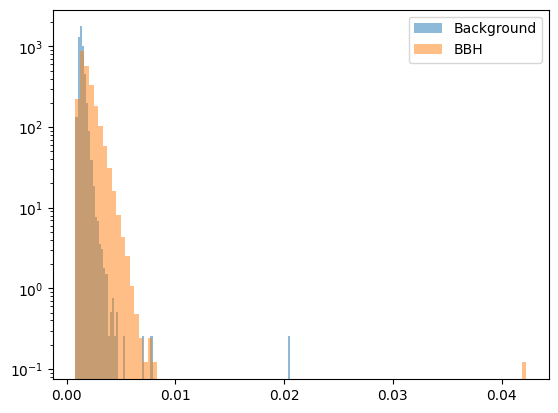

evaluation bg vs sg


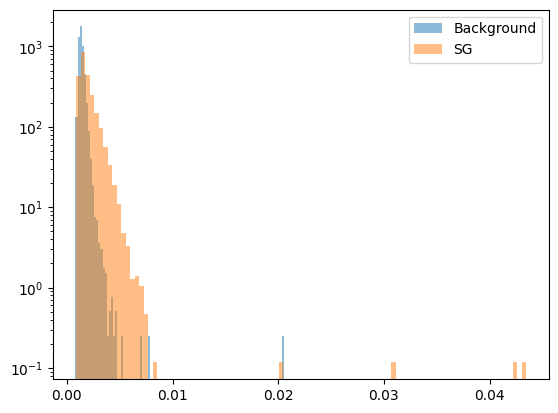

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_29.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


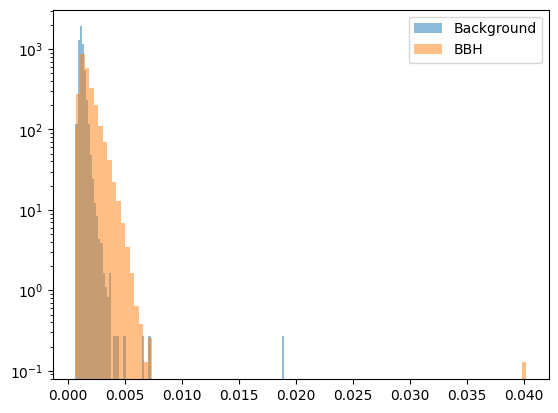

evaluation bg vs sg


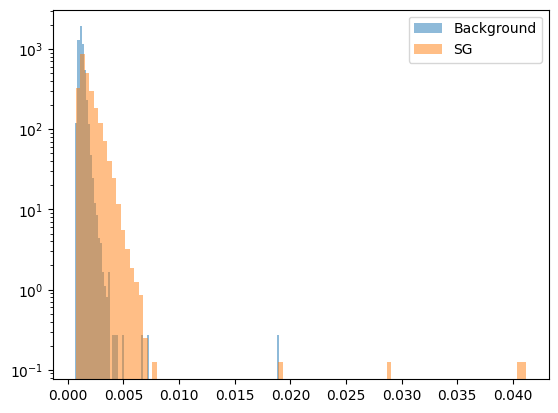

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_30.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


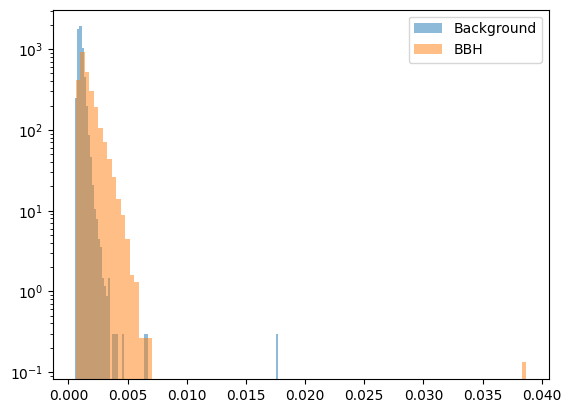

evaluation bg vs sg


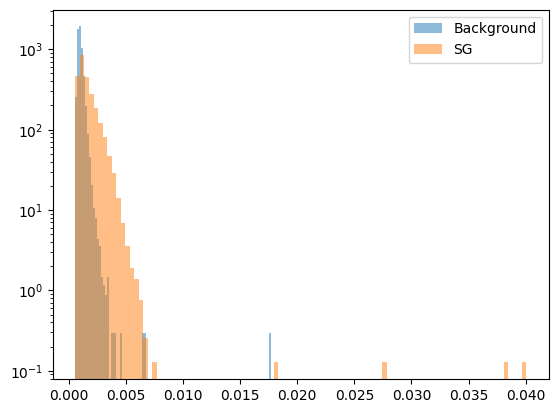

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_31.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


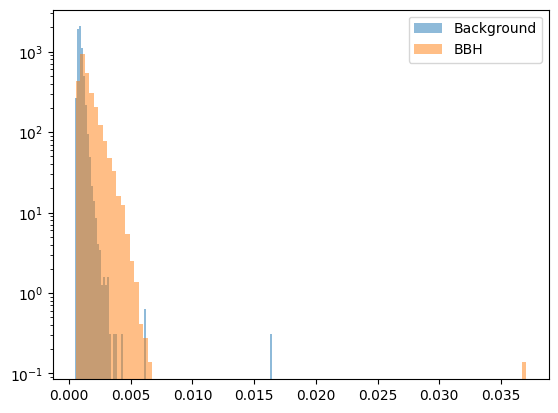

evaluation bg vs sg


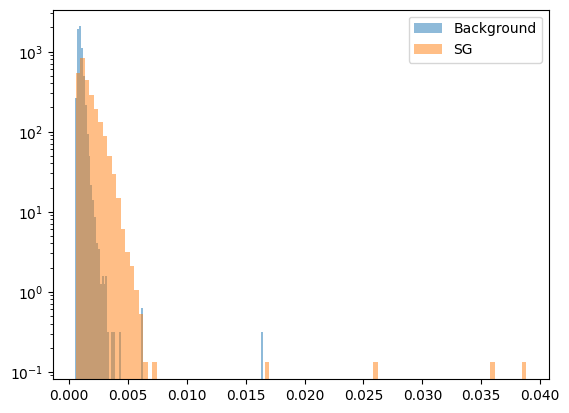

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_32.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


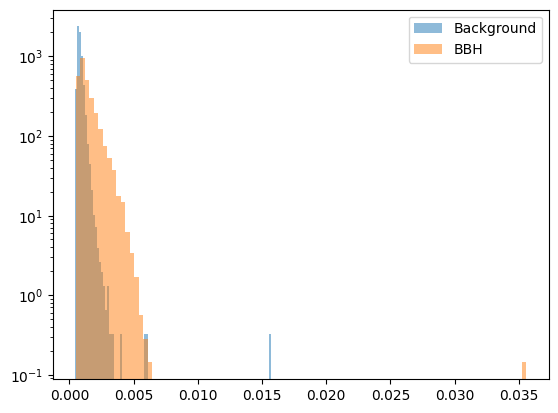

evaluation bg vs sg


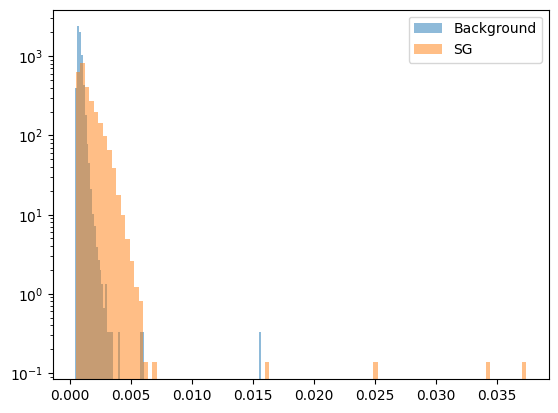

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_33.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


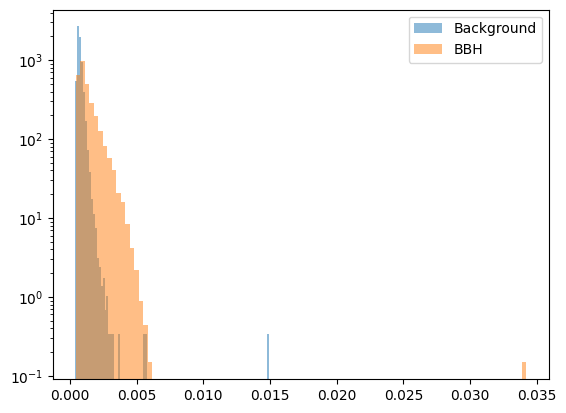

evaluation bg vs sg


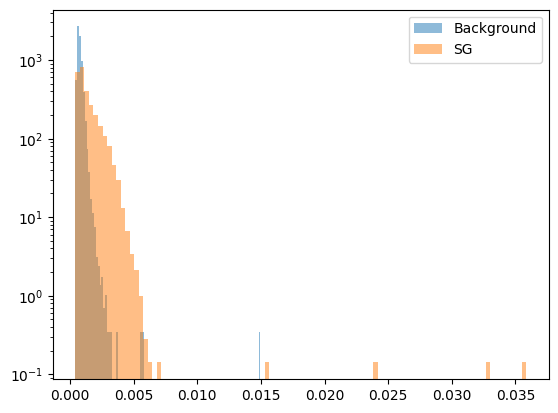

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_34.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


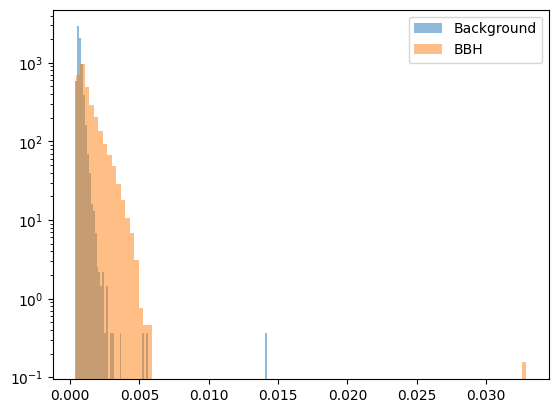

evaluation bg vs sg


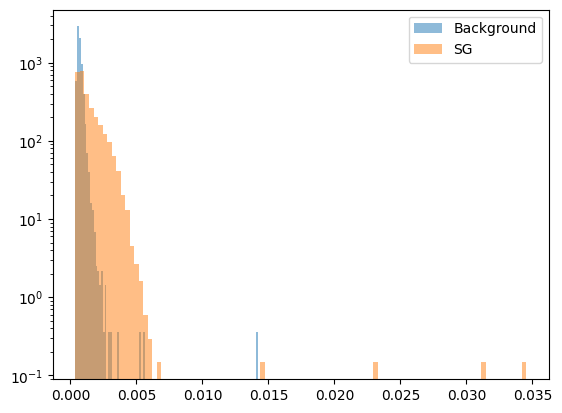

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_35.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


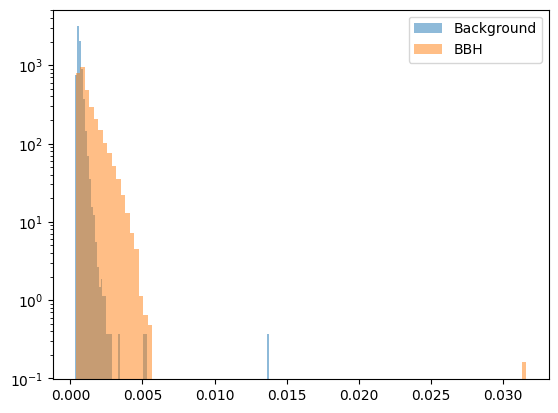

evaluation bg vs sg


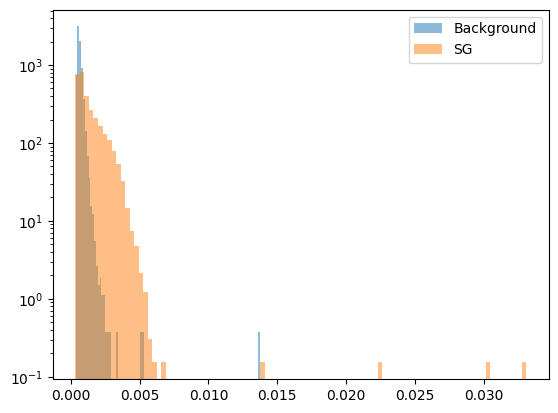

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_36.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


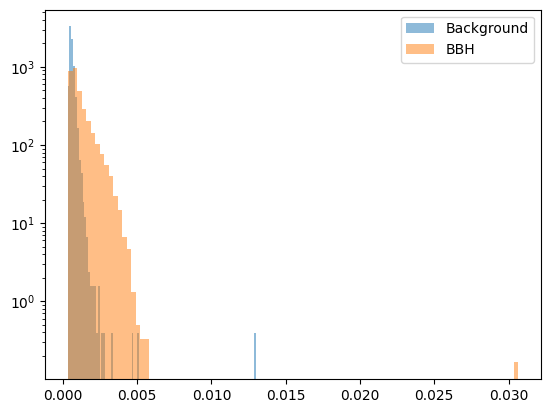

evaluation bg vs sg


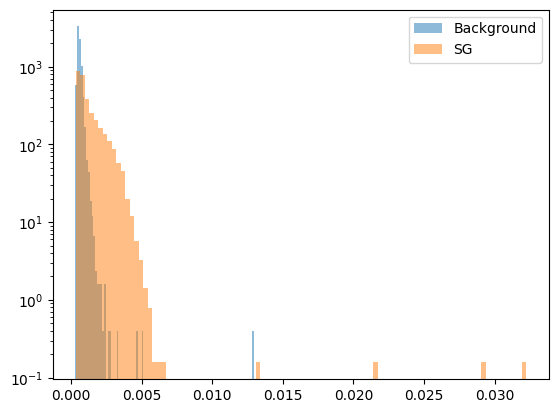

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_37.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


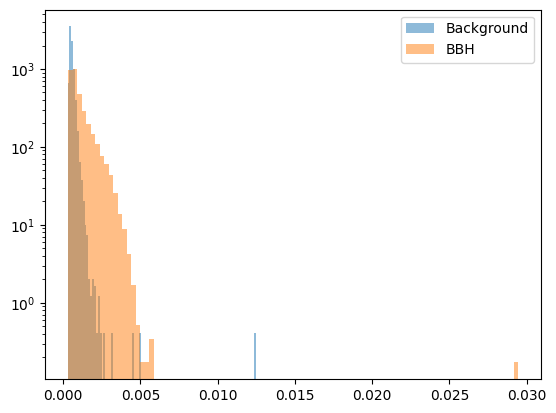

evaluation bg vs sg


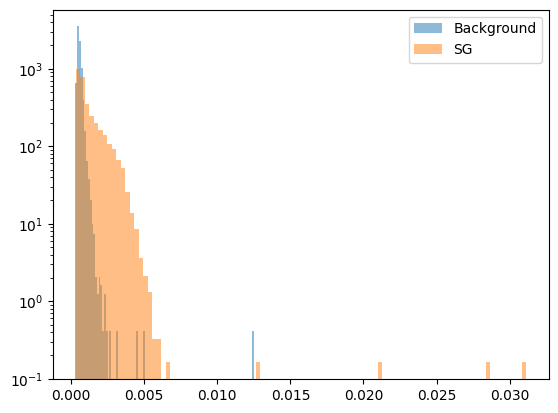

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_38.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


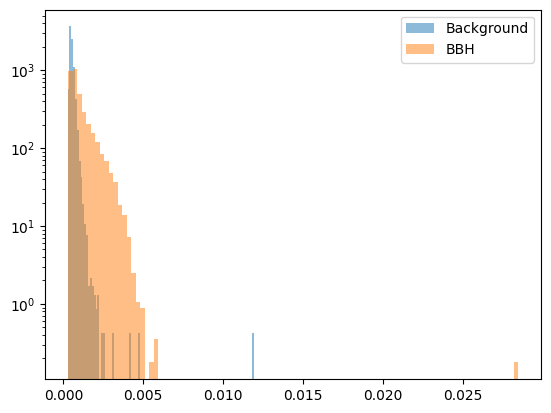

evaluation bg vs sg


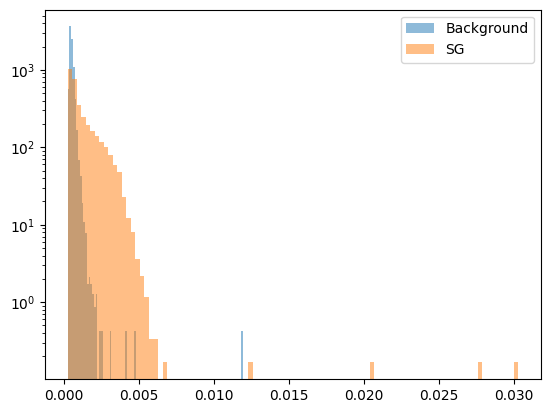

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_39.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


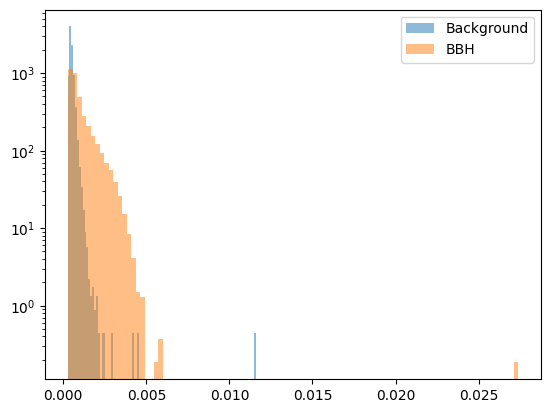

evaluation bg vs sg


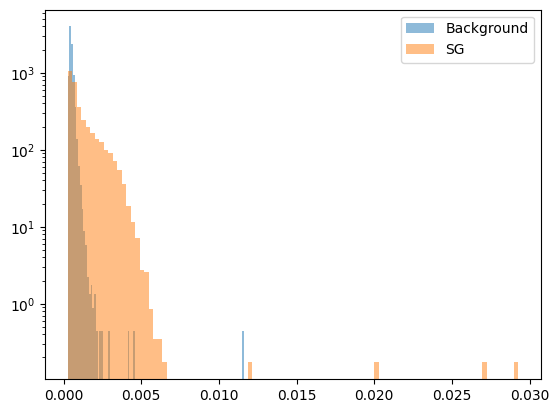

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_40.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


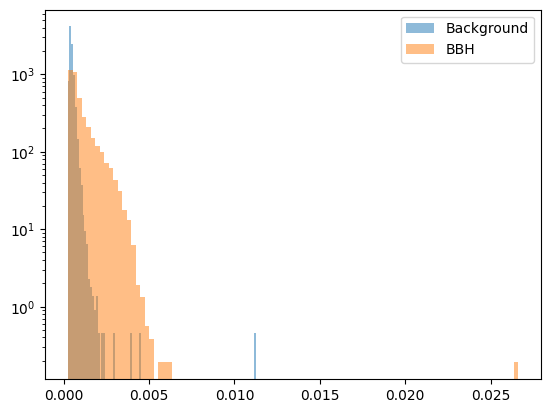

evaluation bg vs sg


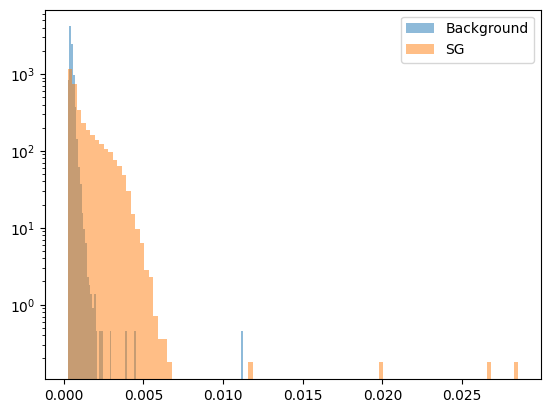

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_41.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


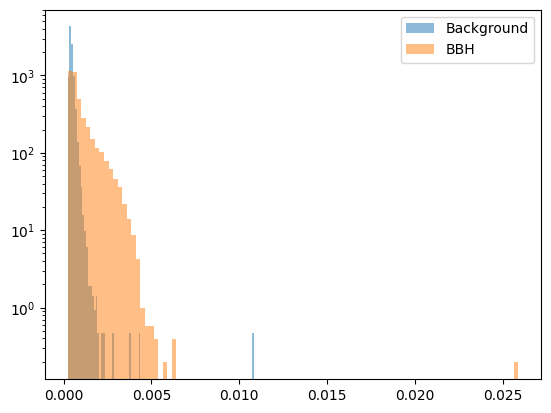

evaluation bg vs sg


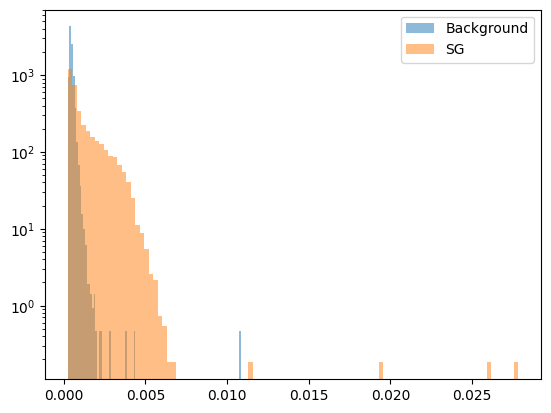

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_42.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


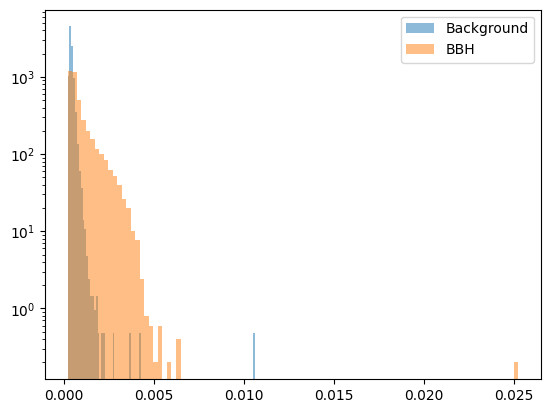

evaluation bg vs sg


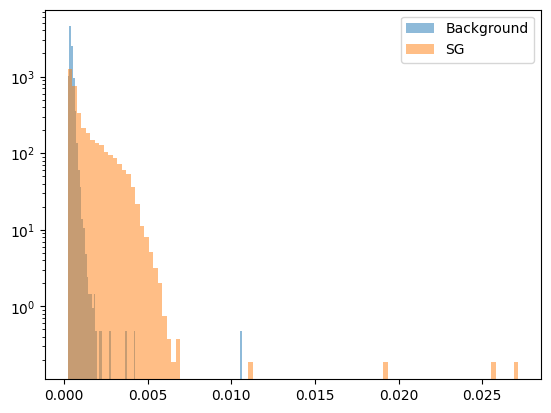

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_43.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


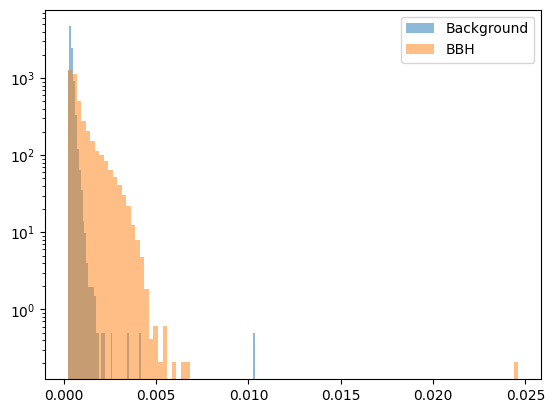

evaluation bg vs sg


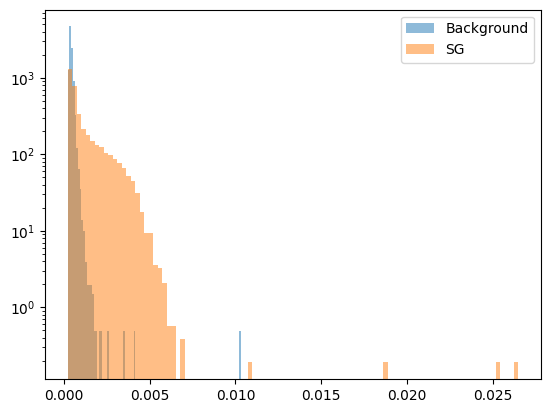

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_44.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


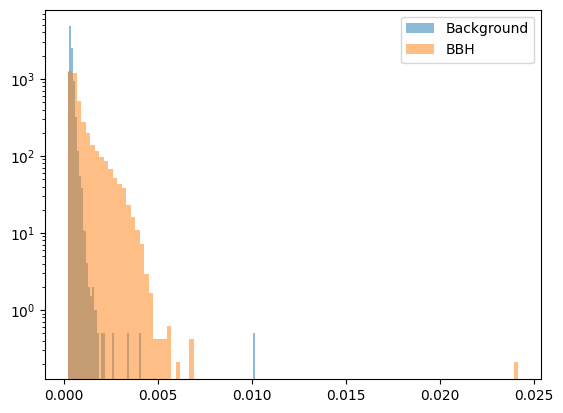

evaluation bg vs sg


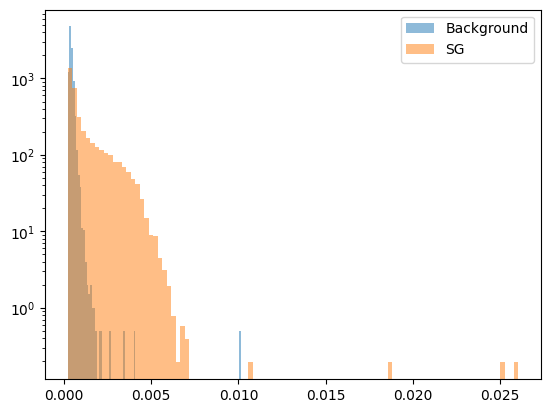

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_45.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


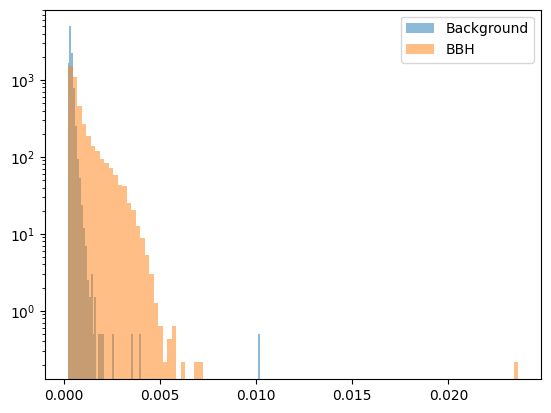

evaluation bg vs sg


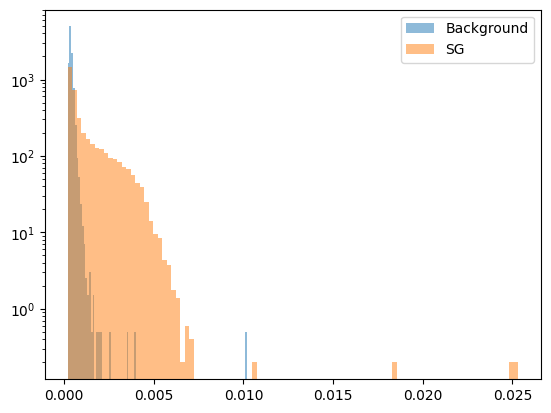

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_46.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


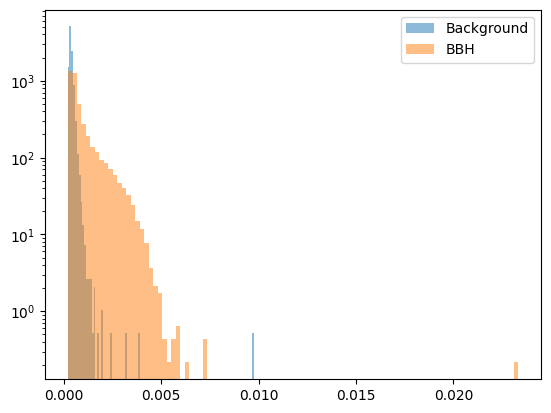

evaluation bg vs sg


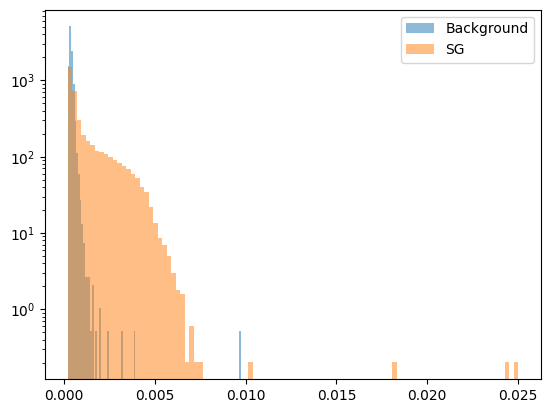

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_47.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


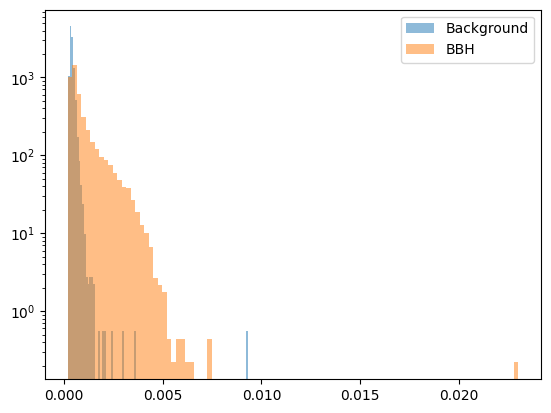

evaluation bg vs sg


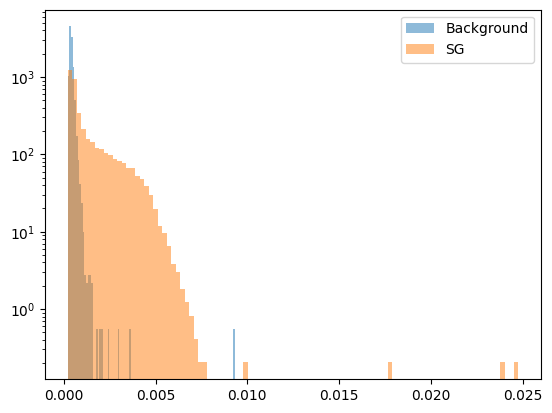

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_48.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


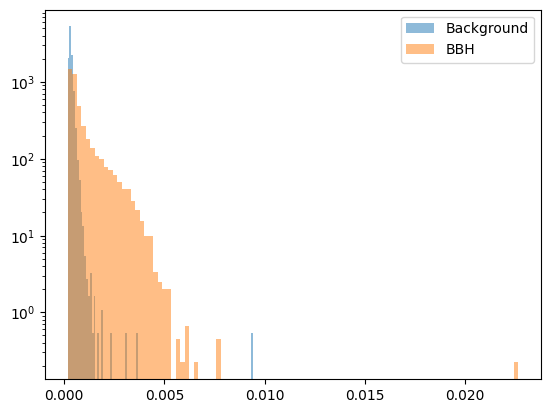

evaluation bg vs sg


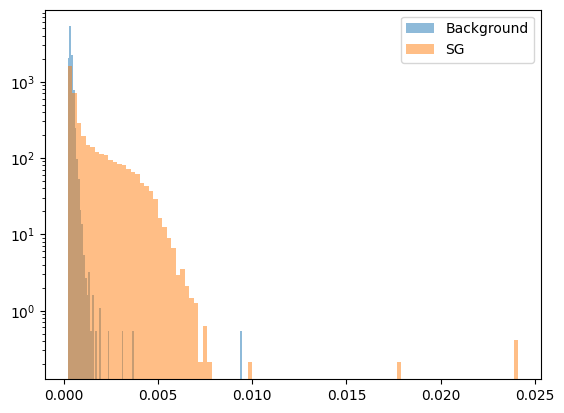

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_49.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


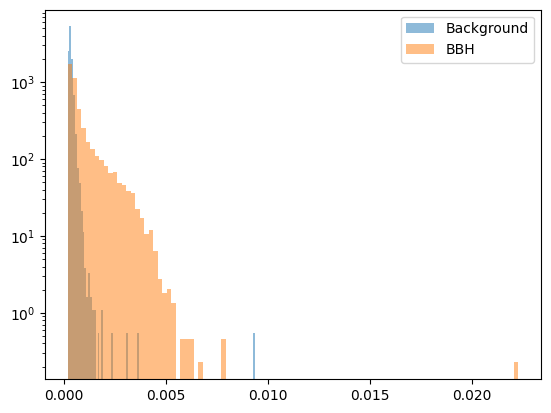

evaluation bg vs sg


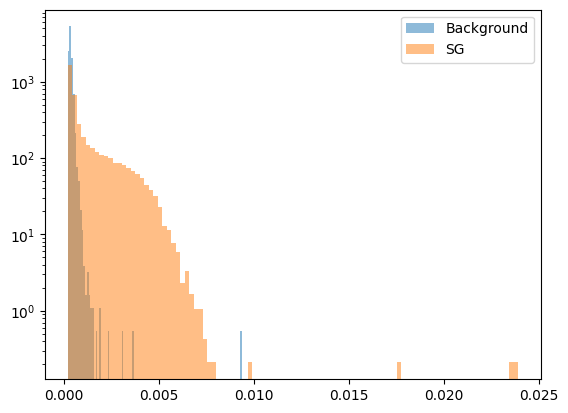

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_50.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


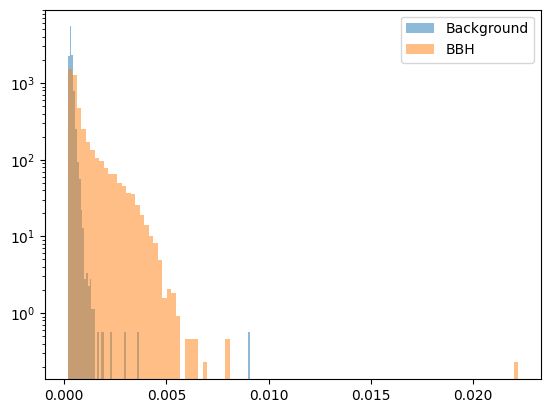

evaluation bg vs sg


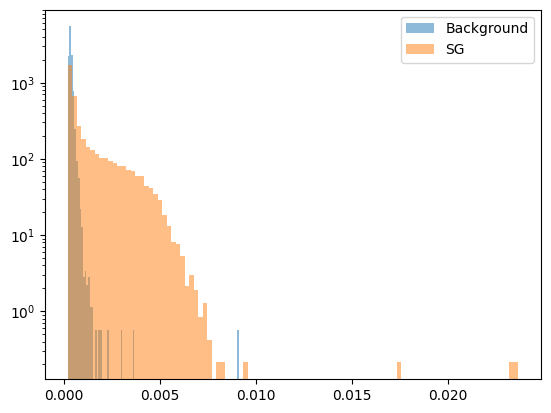

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_51.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


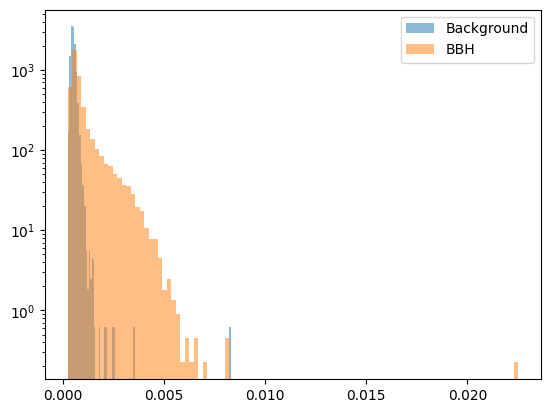

evaluation bg vs sg


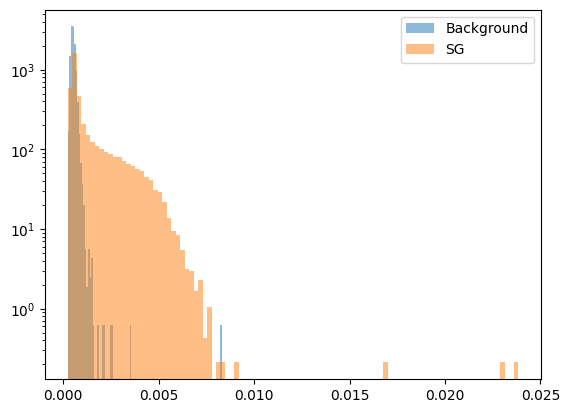

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_52.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


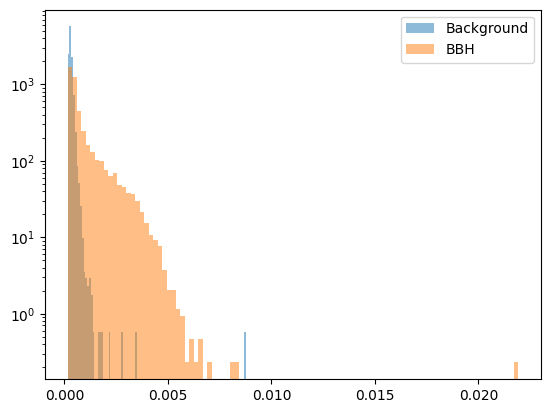

evaluation bg vs sg


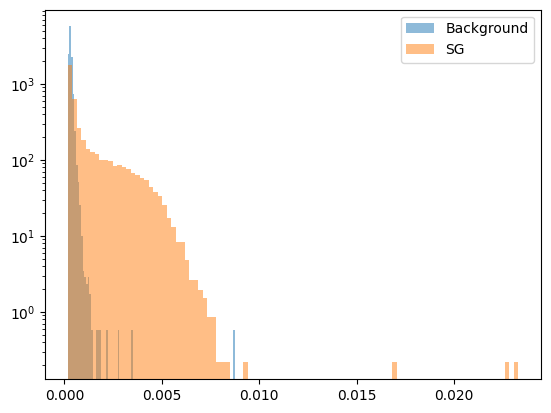

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_53.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


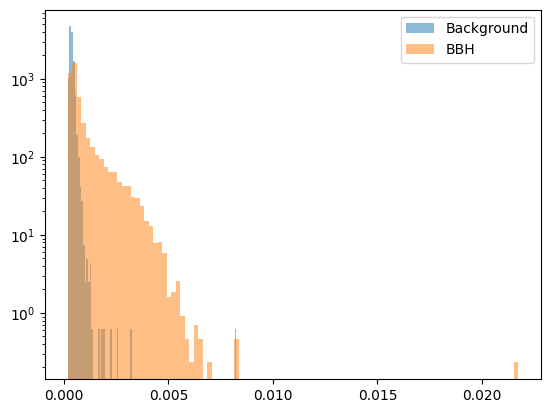

evaluation bg vs sg


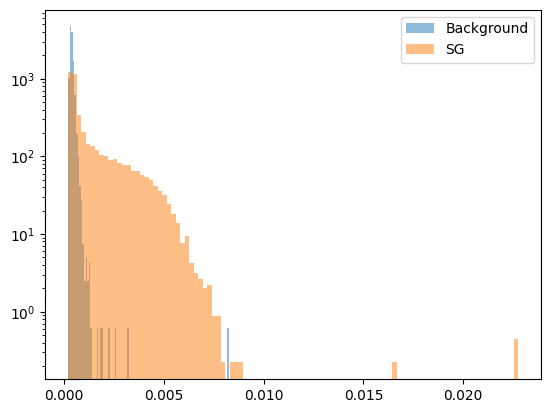

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_54.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


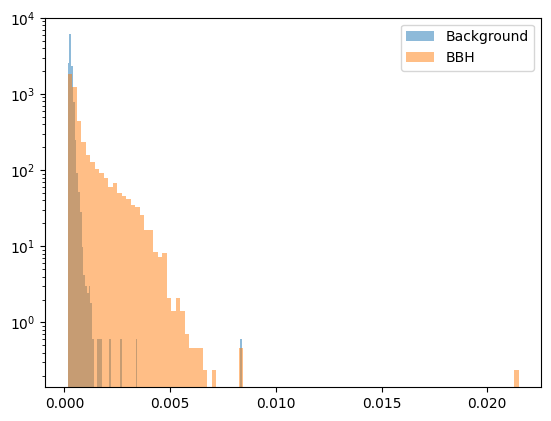

evaluation bg vs sg


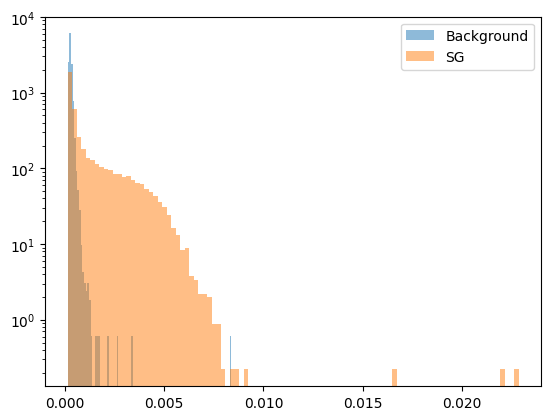

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_55.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


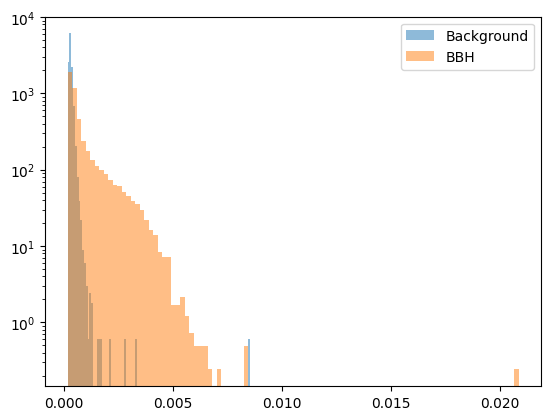

evaluation bg vs sg


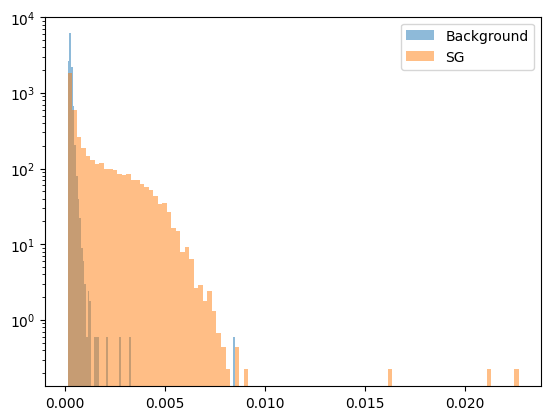

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_56.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


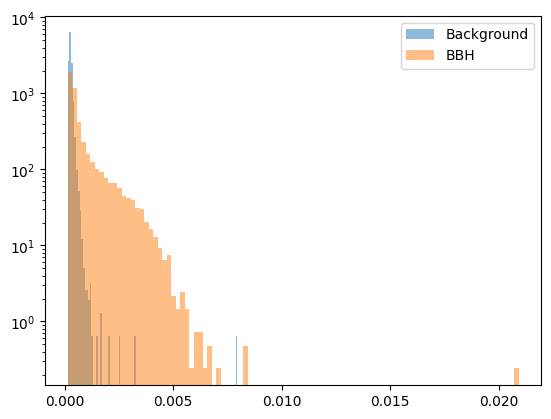

evaluation bg vs sg


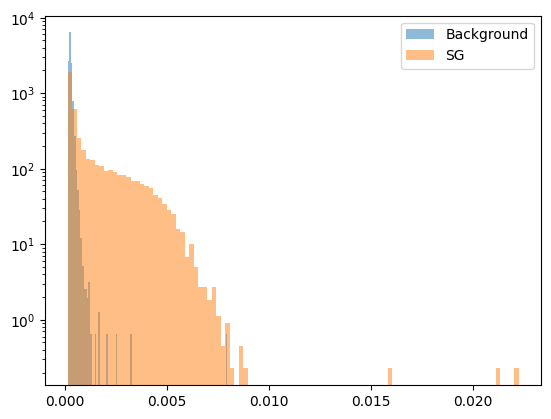

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_57.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


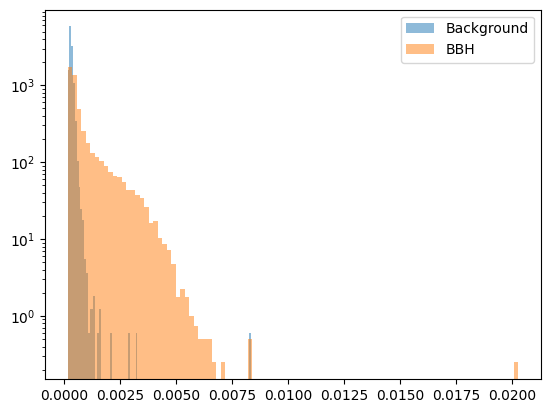

evaluation bg vs sg


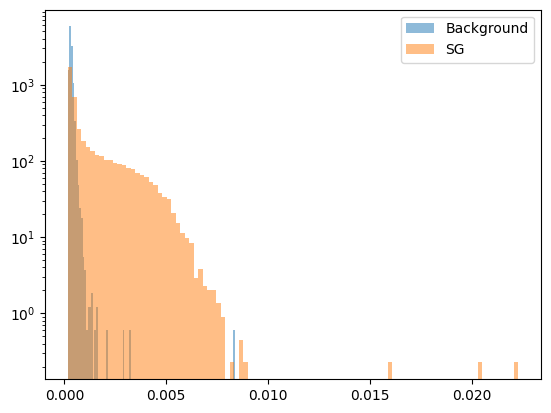

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_58.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


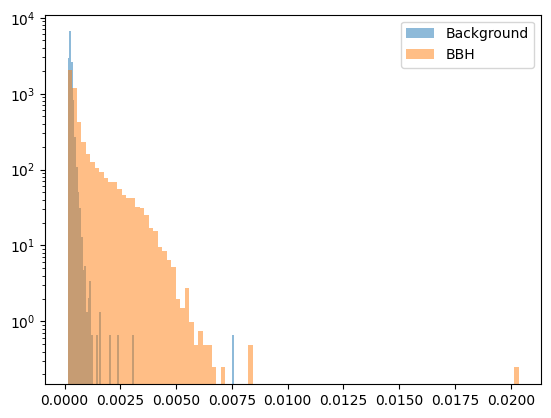

evaluation bg vs sg


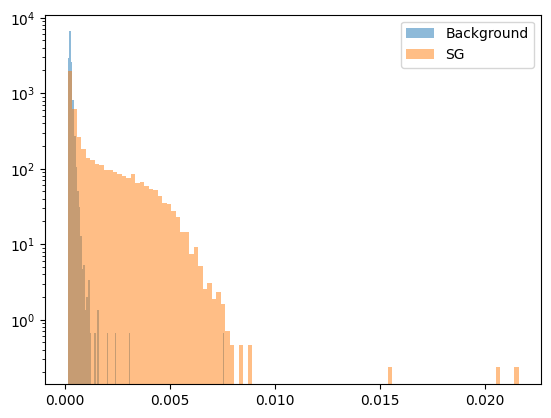

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_59.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


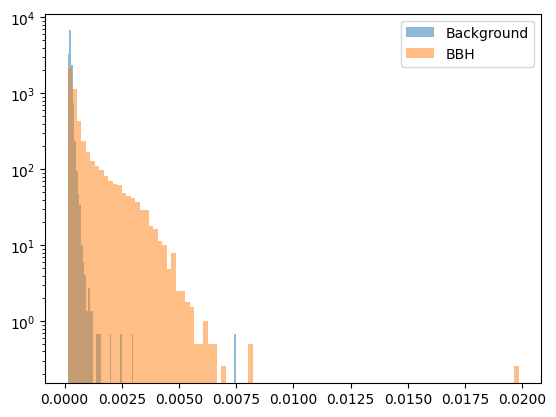

evaluation bg vs sg


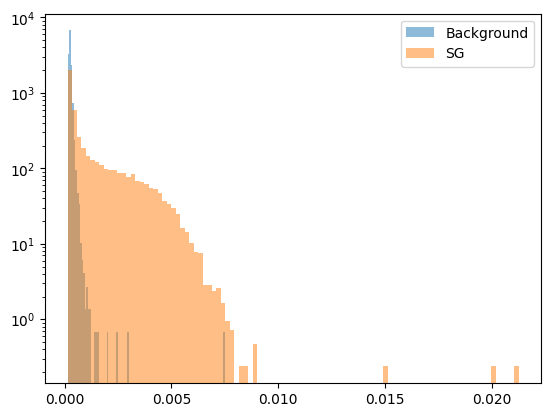

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_60.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
evaluating bg vs bbh


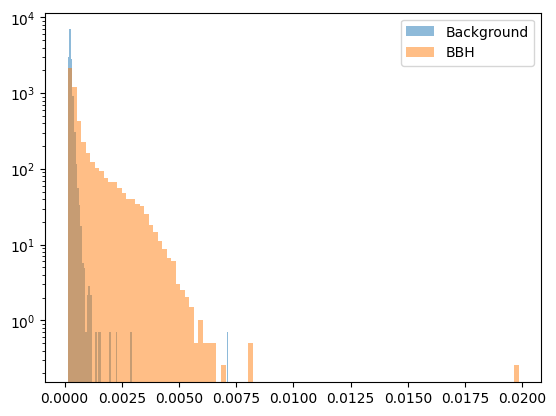

evaluation bg vs sg


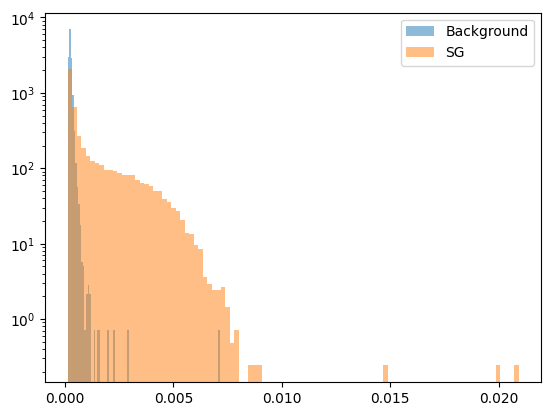

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_61.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


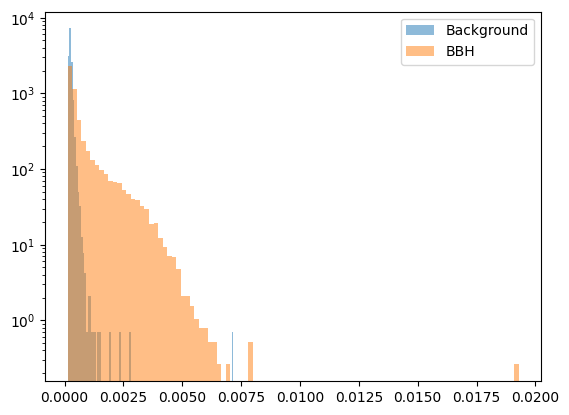

evaluation bg vs sg


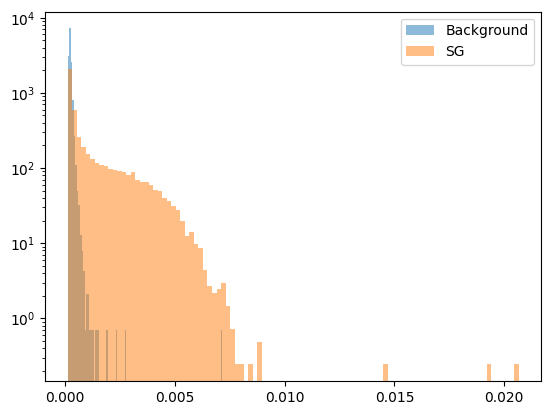

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_62.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


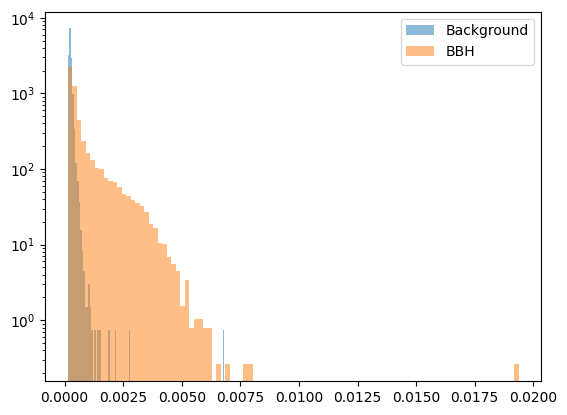

evaluation bg vs sg


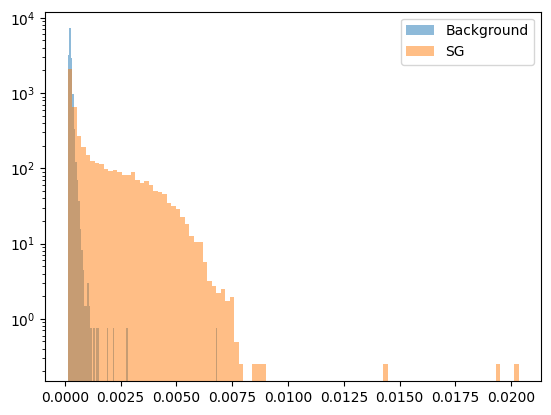

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_63.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
evaluating bg vs bbh


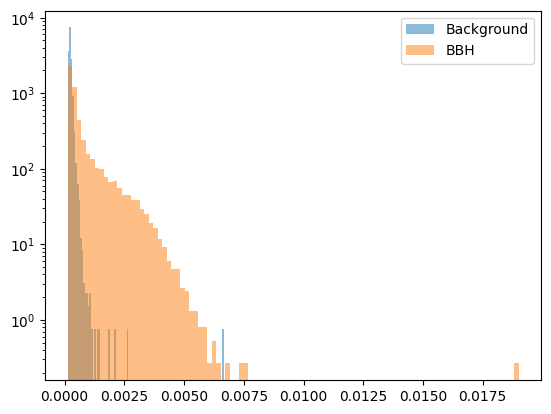

evaluation bg vs sg


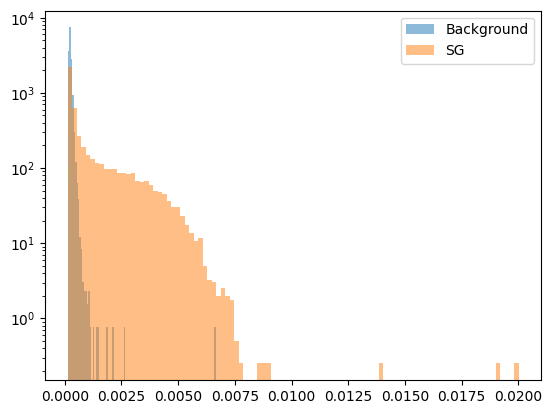

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_64.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


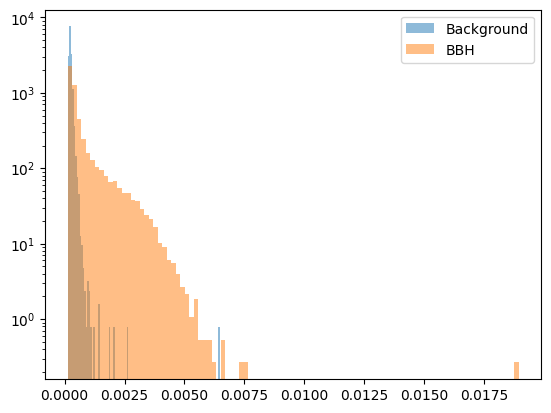

evaluation bg vs sg


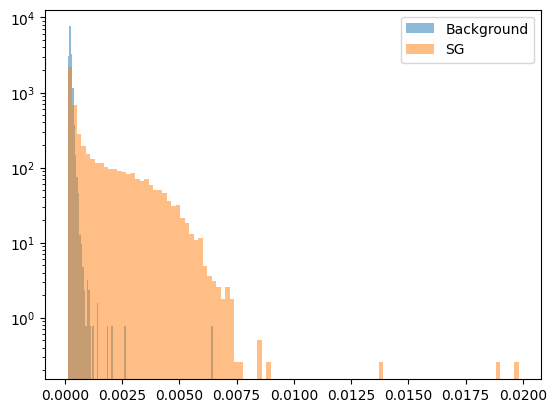

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_65.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


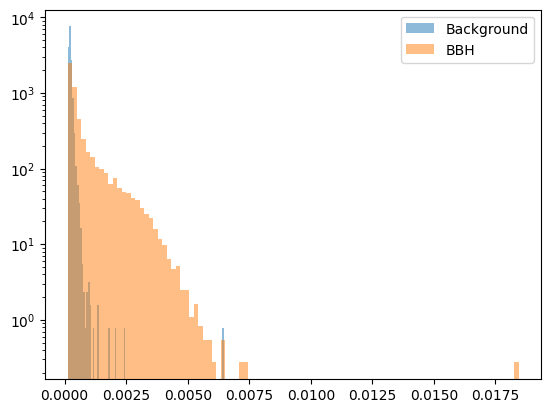

evaluation bg vs sg


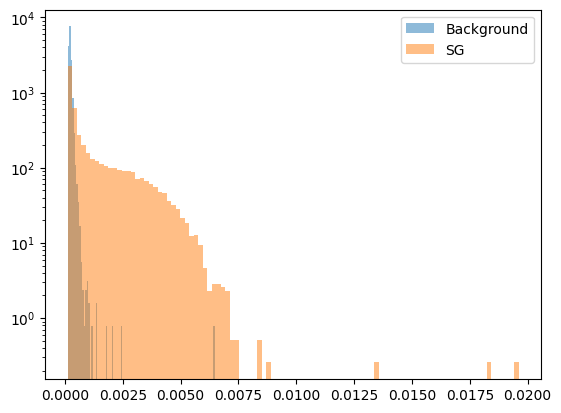

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_66.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


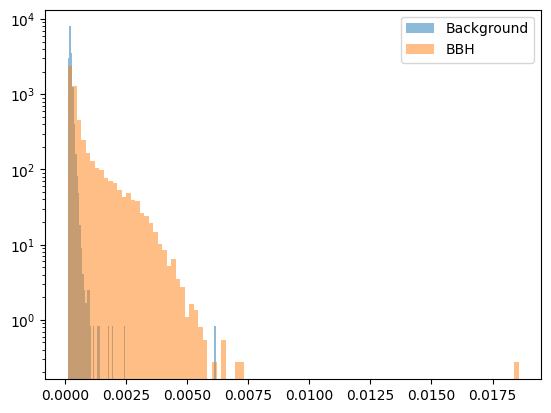

evaluation bg vs sg


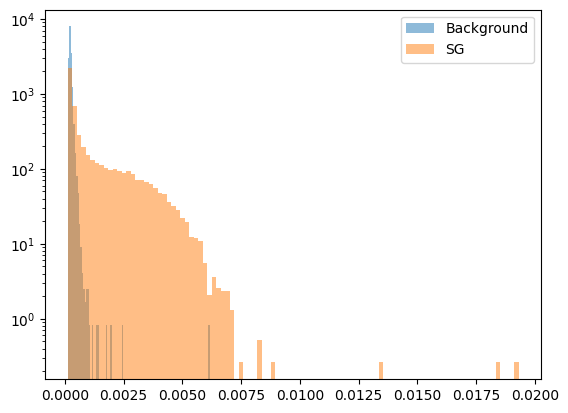

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_67.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


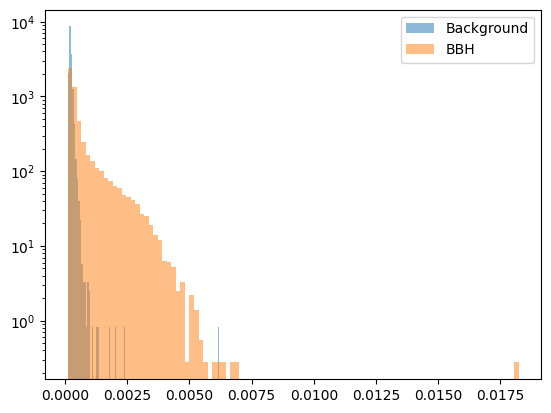

evaluation bg vs sg


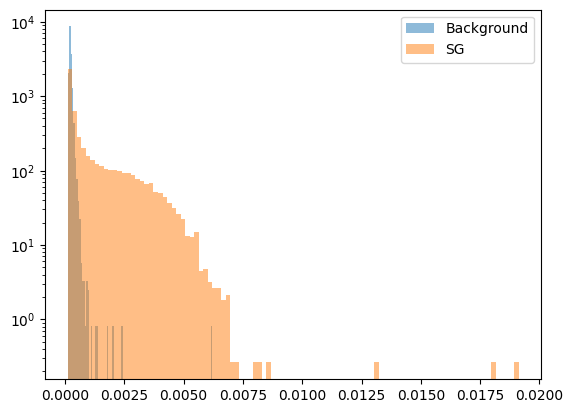

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_68.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
evaluating bg vs bbh


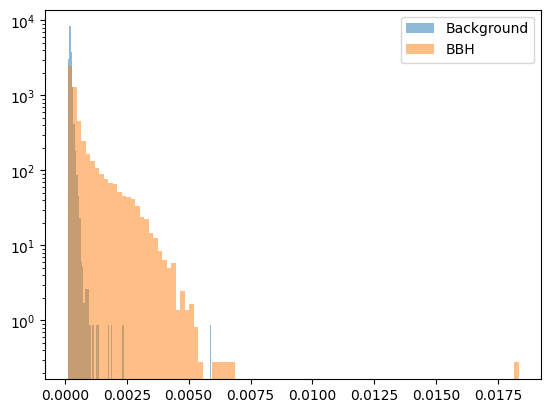

evaluation bg vs sg


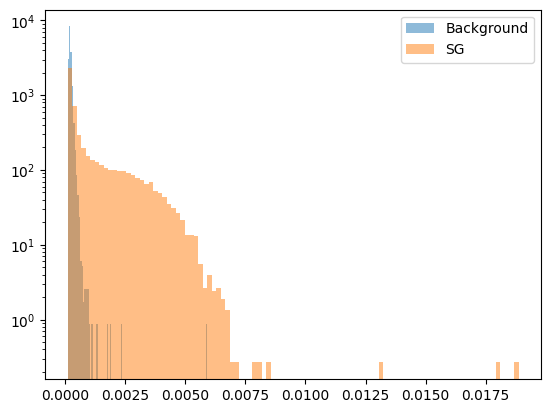

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_69.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
evaluating bg vs bbh


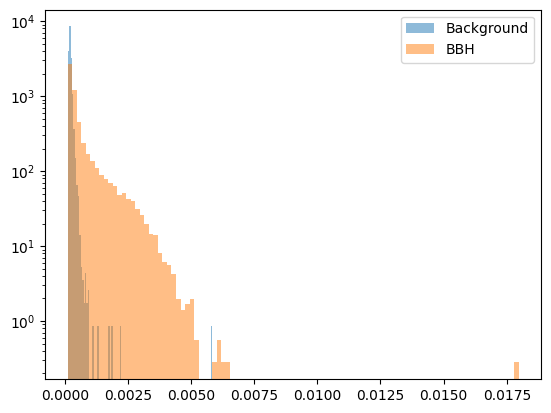

evaluation bg vs sg


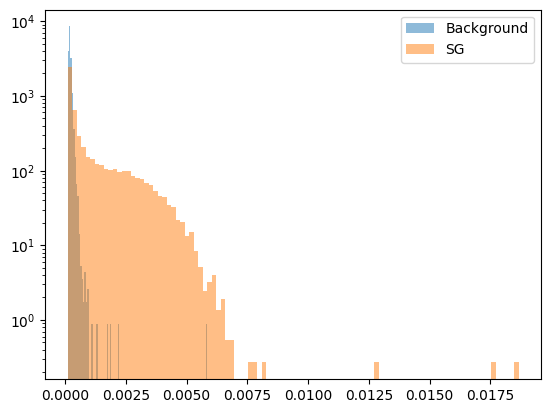

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_70.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
evaluating bg vs bbh


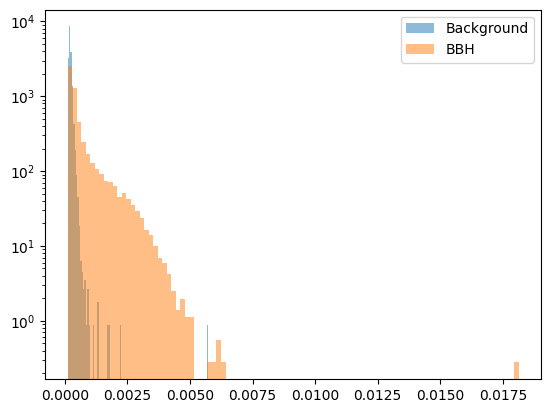

evaluation bg vs sg


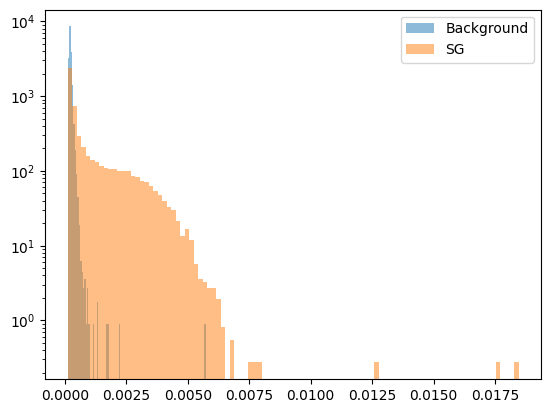

In [11]:
from tensorflow.keras.models import load_model
# this is from the original condabench challenge sample code, It gives Auc_loss, and the FPR(I added it) 0.9 TPR
def make_plot_roc_curves(qcd, bsm):   #qcd is set to be zero which is bg, bsm is set to be 1 which is anomaly
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))  #create the true value
    pred_val = np.concatenate((bsm, qcd))   #concatenate the predicted value
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)  #find the fpr, tpr, and threshold
    idx = np.argmin(np.abs(tpr_loss - 0.90))    #nearest value's index at 0.9 TPR
    desired_fpr = fpr_loss[idx]    #FPR at 0.9 TPR
    desired_threshold = threshold_loss[idx]

    auc_loss = auc(fpr_loss, tpr_loss)
    qcd[::-1].sort()
    # plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
    #     linewidth=1.5)
    # plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
    # plt.ylabel('True Positive Rate')
    # plt.xlabel('False Positive Rate')
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()
    return auc_loss, desired_fpr

# the eval function evaluate bg vs bbh and bg vs sg, x_test meant to be the input of background_test, bbh_pretest meant to be bbh_test, sglf_pretest meant to be sglf_test
# it then gives the auc_loss, desired fpr for both comparisons. Also plot the graph for both comparisons ( bg vs bbh, bg vs sg )
def eval(model,x_test,bbh_pretest,sglf_pretest):
    background_test = model.predict(x_test)['transformer_output']
    bbh_test = model.predict(bbh_pretest)['transformer_output']
    sglf_test = model.predict(sglf_pretest)['transformer_output']
    mse_background = np.mean((background_test - x_test)**2, axis=(1,2))
    mse_bbh = np.mean((bbh_test - bbh_pretest)**2, axis=(1,2))
    mse_sg = np.mean((sglf_test - sglf_pretest)**2, axis=(1,2))
    print('evaluating bg vs bbh')
    BBH_AUC, desired_fpr_bbh = make_plot_roc_curves(mse_background, mse_bbh)
    plt.hist(mse_background, density=True, bins=100, alpha=0.5, label='Background')
    plt.hist(mse_bbh, density=True, bins=100, alpha=0.5, label='BBH')
    plt.semilogy()
    plt.legend()
    plt.show()
    print('evaluation bg vs sg')
    SG_AUC, desired_fpr_sg = make_plot_roc_curves(mse_background, mse_sg)
    plt.hist(mse_background, density=True, bins=100, alpha=0.5, label='Background')
    plt.hist(mse_sg, density=True, bins=100, alpha=0.5, label='SG')
    plt.semilogy()
    plt.legend()
    plt.show()
    return BBH_AUC, SG_AUC, desired_fpr_bbh, desired_fpr_sg


model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_*.keras")
# sort it so it wont start at a random epoch
model_files = sorted(model_files, key=lambda x: int(re.search(r"model_epoch_(\d+).keras", x).group(1)))
bbh_auc=[]
sg_auc=[]
fpr_bbh=[]
fpr_sg=[]

#get the auc and fpr at each epochs
for model_name in model_files[:70]:
    print(f"Evaluating model: {model_name}")
    model = load_model(model_name, custom_objects={"masked_mse_loss": masked_mse_loss,"TriangularCyclicalLearningRate": TriangularCyclicalLearningRate})
    BBH_AUC, SG_AUC, desired_fpr_bbh, desired_fpr_sg = eval(model,background_test, bbh_test,sglf_test)
    bbh_auc.append(BBH_AUC)
    sg_auc.append(SG_AUC)
    fpr_bbh.append(desired_fpr_bbh)
    fpr_sg.append(desired_fpr_sg)



bbh 0.8059164375000001 68
sg 0.793555275 46


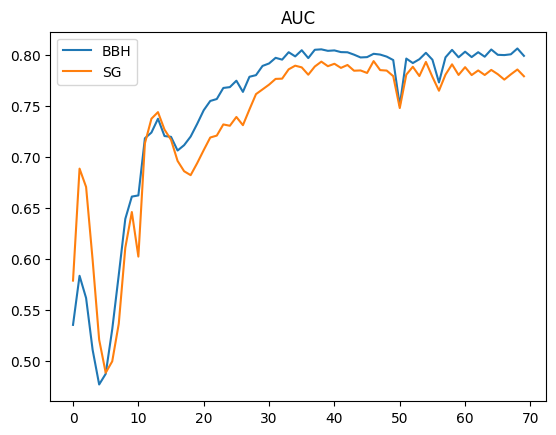

bbh 0.61765 68
sg 0.6924 34


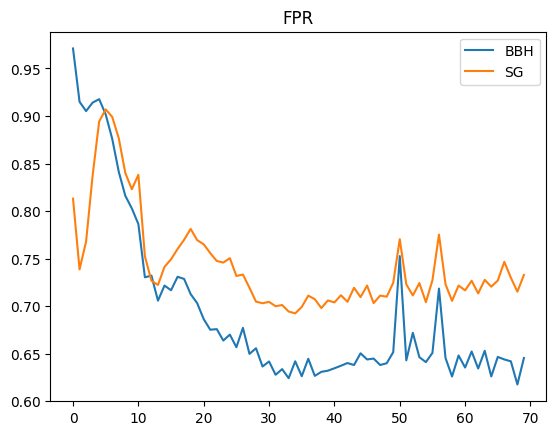

In [12]:
#plot the trend of auc and fpr
plt.figure()
plt.plot(bbh_auc, label='BBH')
plt.plot(sg_auc, label='SG')
print('bbh',max(bbh_auc),bbh_auc.index(max(bbh_auc)))
print('sg',max(sg_auc),sg_auc.index(max(sg_auc)))
plt.title('AUC')
plt.legend()
plt.show()

plt.figure()
plt.plot(fpr_bbh, label='BBH')
plt.plot(fpr_sg, label='SG')
print('bbh',min(fpr_bbh),fpr_bbh.index(min(fpr_bbh)))
print('sg',min(fpr_sg),fpr_sg.index(min(fpr_sg)))
plt.title('FPR')
plt.legend()
plt.show()



Testing


In [13]:
# Load test data and normalize them
data = np.load('ligo_bb_final.npz')
test_data = data['data']
stds = np.std(test_data, axis=-1)[:, :, np.newaxis]
test_data = test_data/stds
test_data = np.swapaxes(test_data, 1, 2)
data_label = data['ids']
indices1 = np.where(data_label == 1)[0]
indices0 = np.where(data_label == 0)[0]
background_test_data = test_data[indices0]
signal_test_data = test_data[indices1]
# Load model
model_files = glob.glob("/content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_*.keras")
model_files = sorted(model_files, key=lambda x: int(re.search(r"model_epoch_(\d+).keras", x).group(1)))


Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_01.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


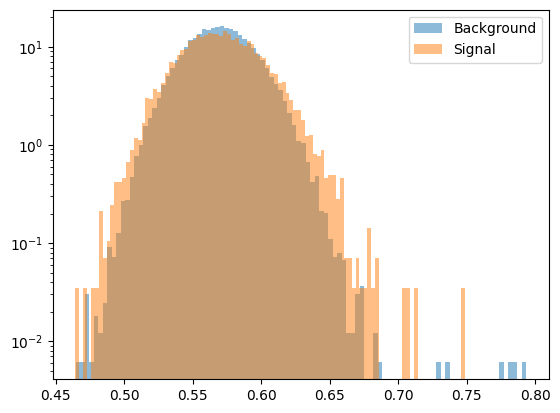

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_02.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


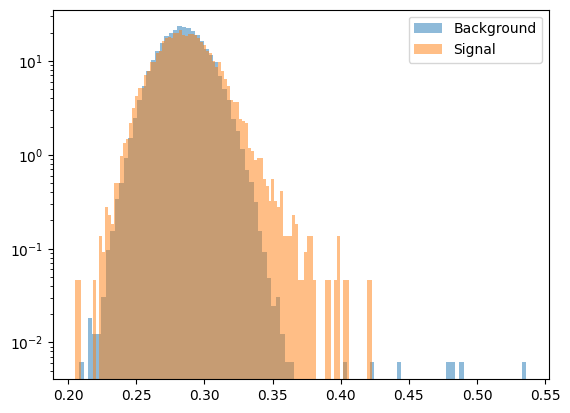

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_03.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


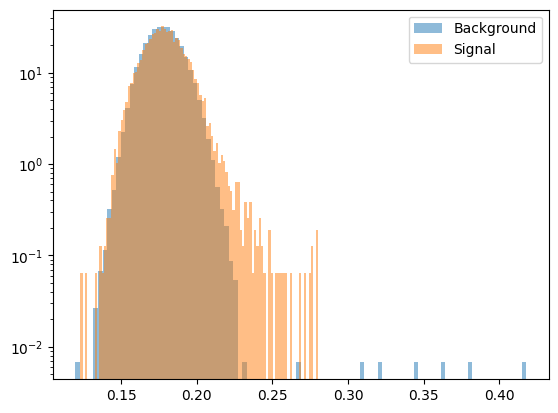

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_04.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


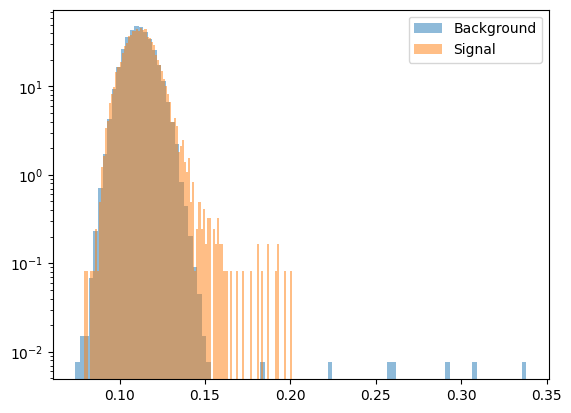

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_05.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


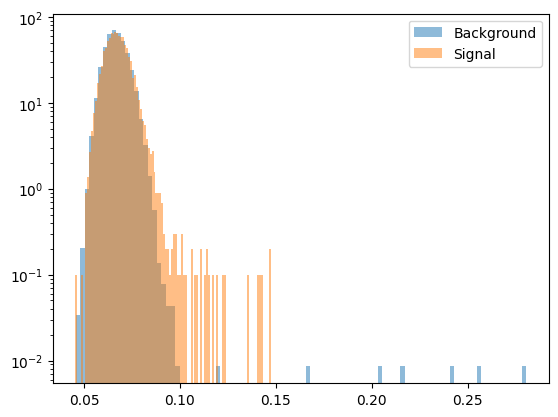

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_06.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


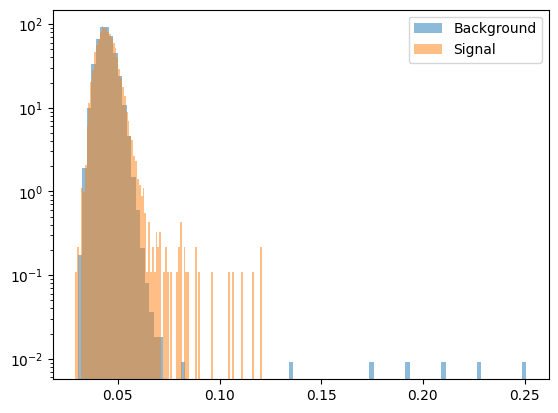

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_07.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


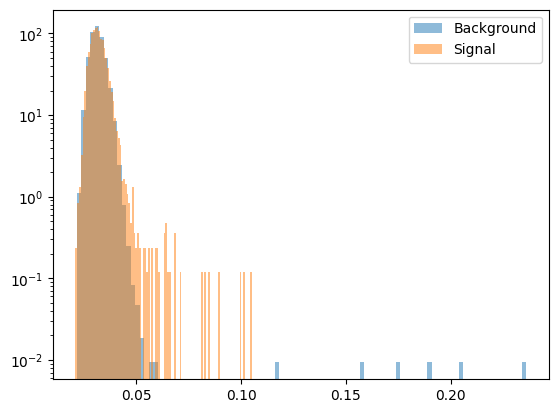

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_08.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


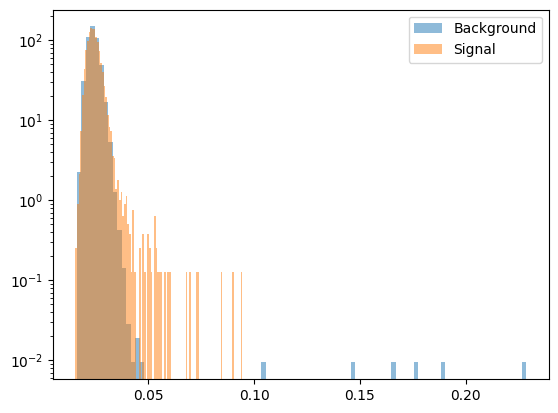

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_09.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


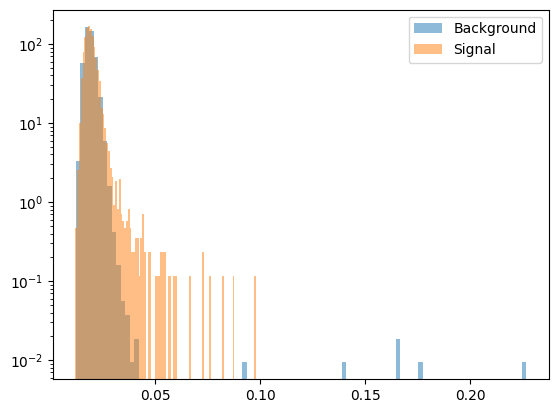

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_10.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


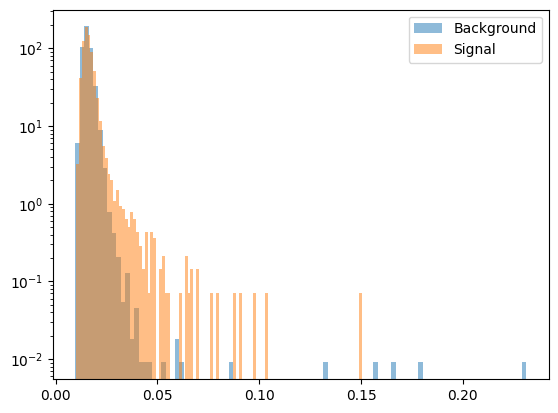

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_11.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


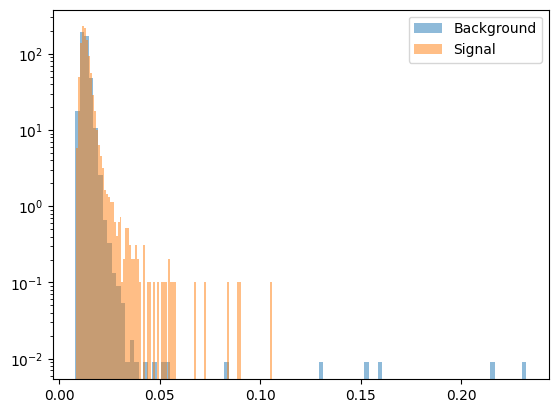

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_12.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


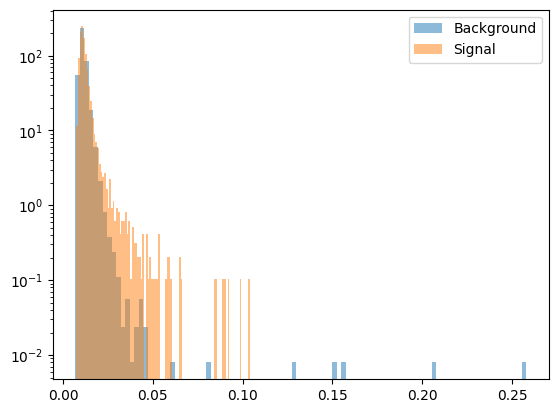

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_13.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


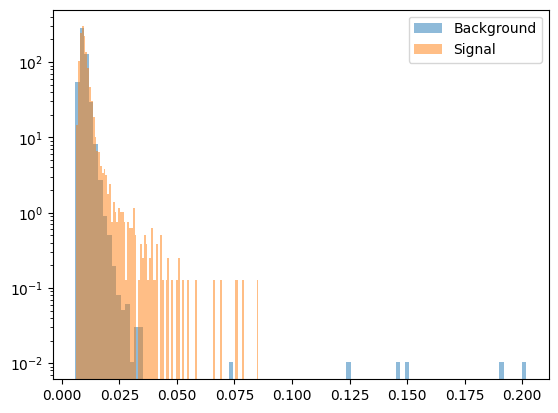

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_14.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


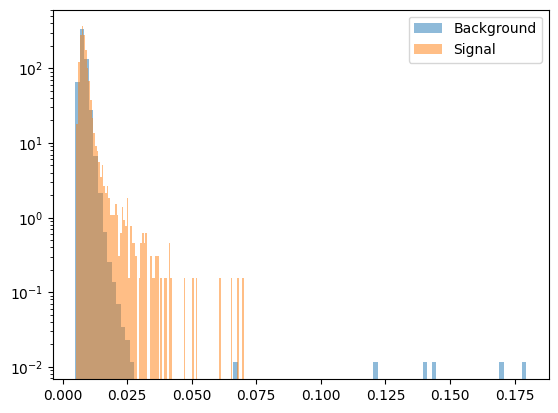

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_15.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


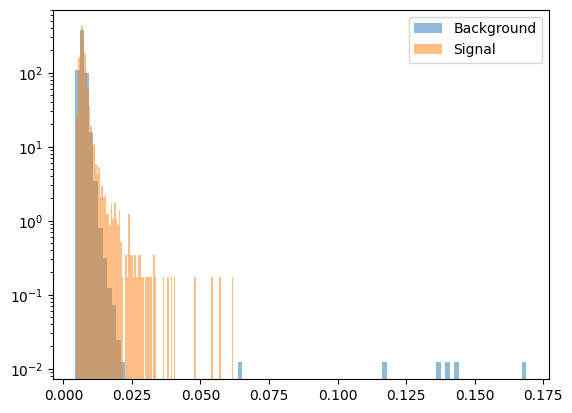

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_16.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


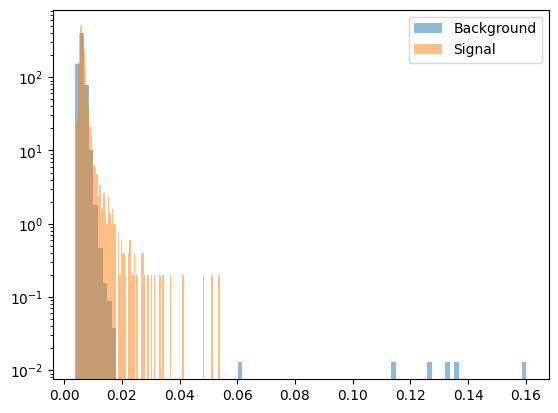

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_17.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


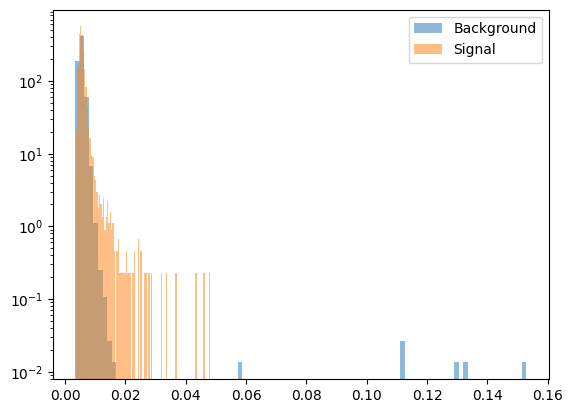

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_18.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


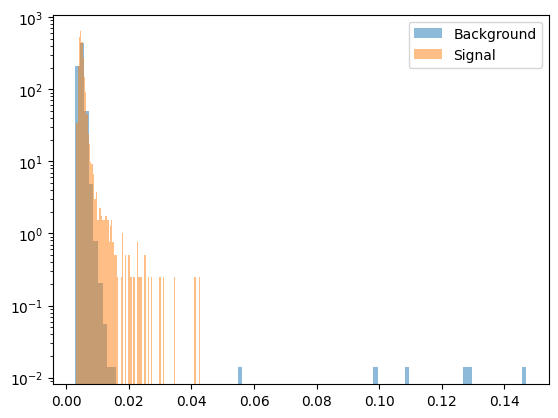

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_19.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


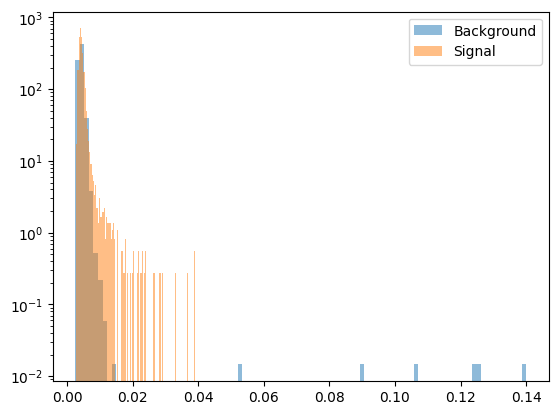

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_20.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


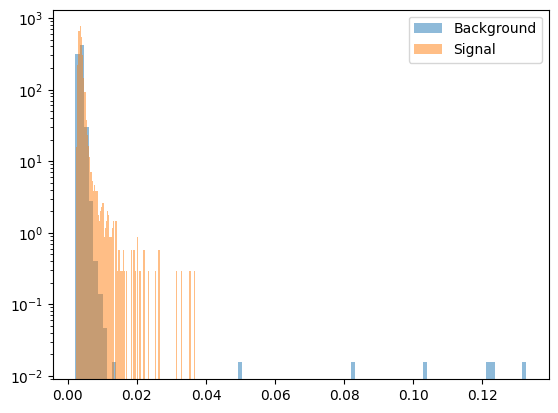

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_21.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


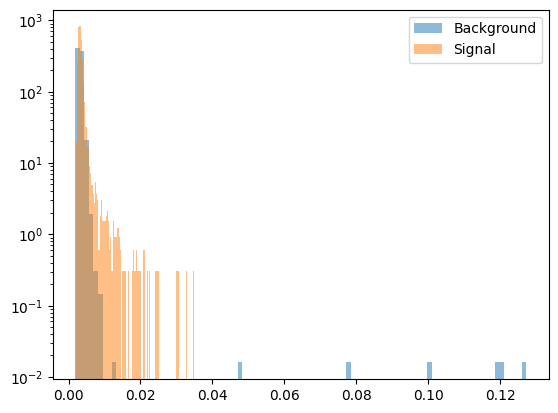

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_22.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


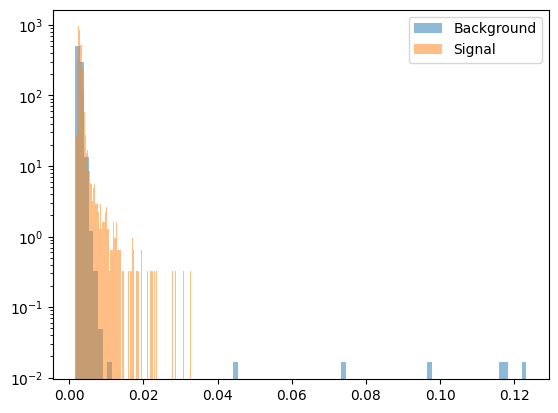

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_23.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


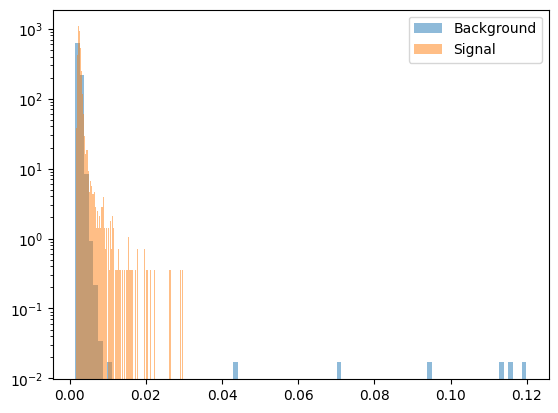

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_24.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


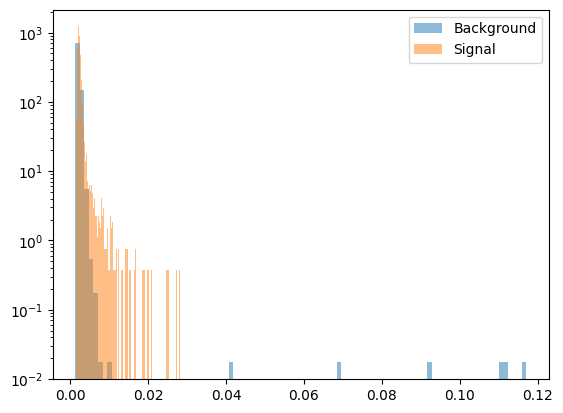

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_25.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


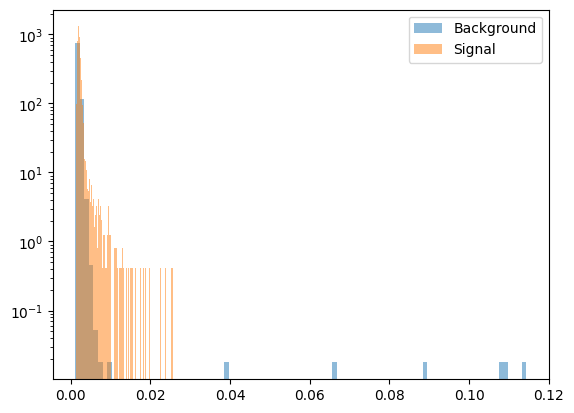

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_26.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


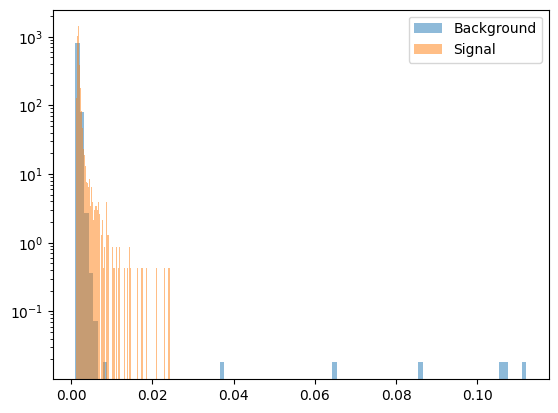

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_27.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


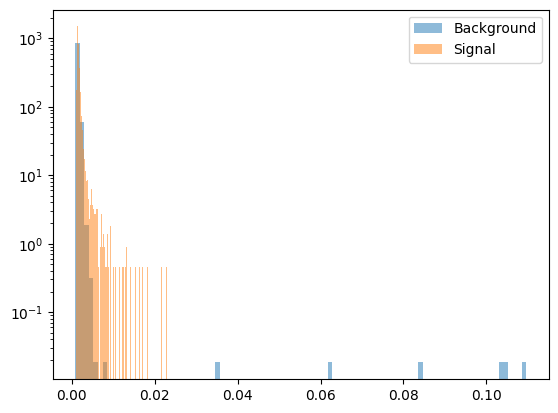

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_28.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


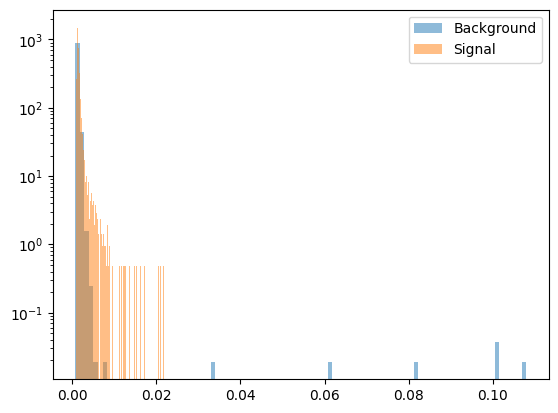

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_29.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


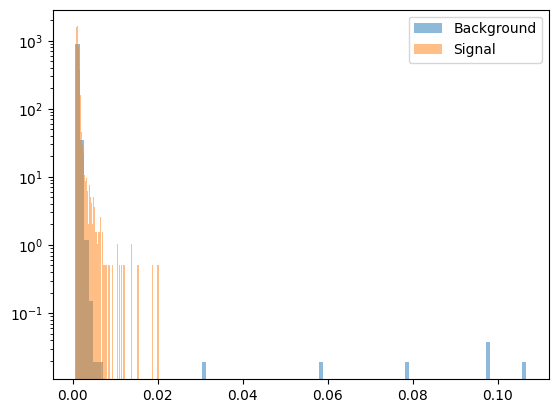

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_30.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


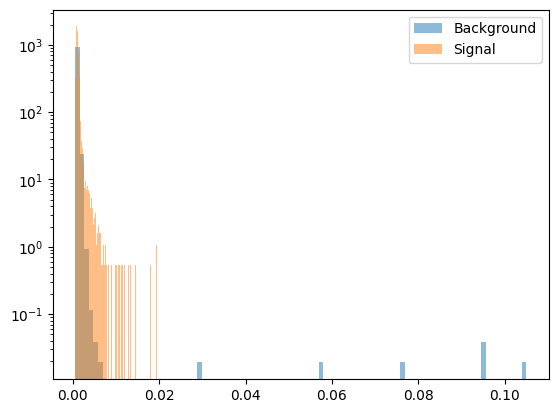

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_31.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


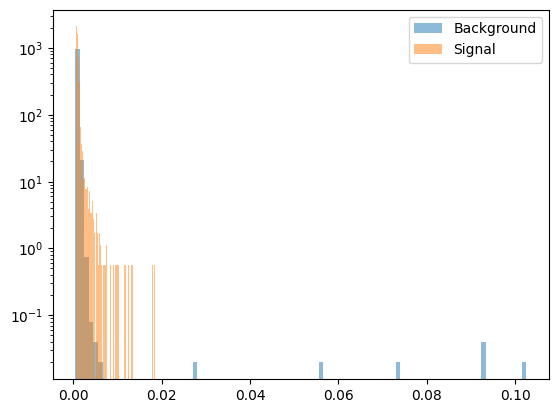

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_32.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


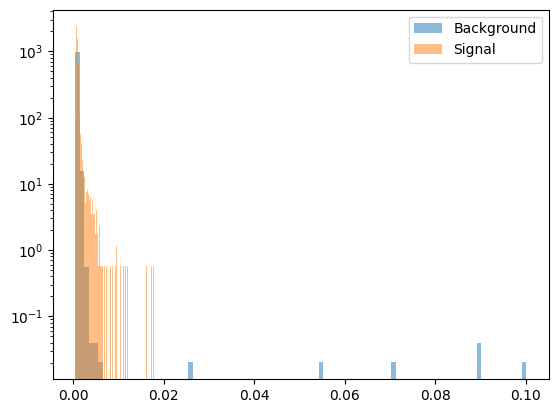

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_33.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


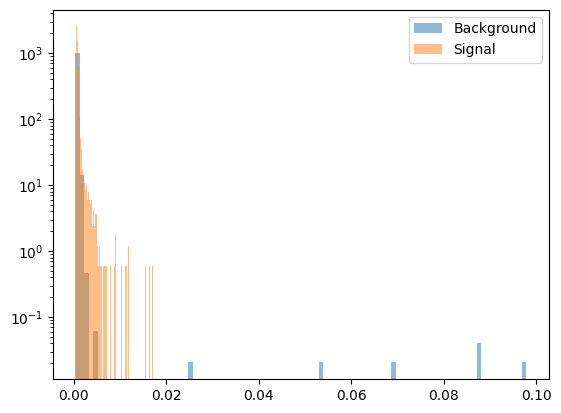

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_34.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


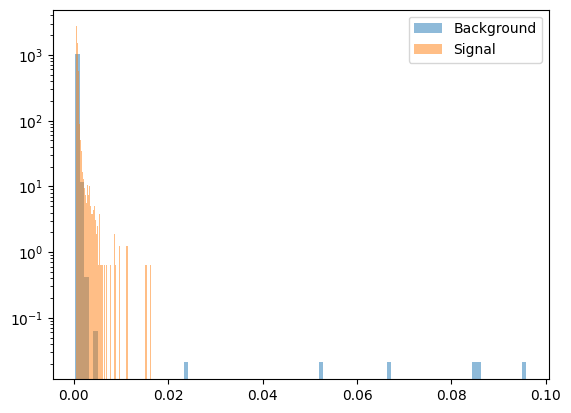

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_35.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


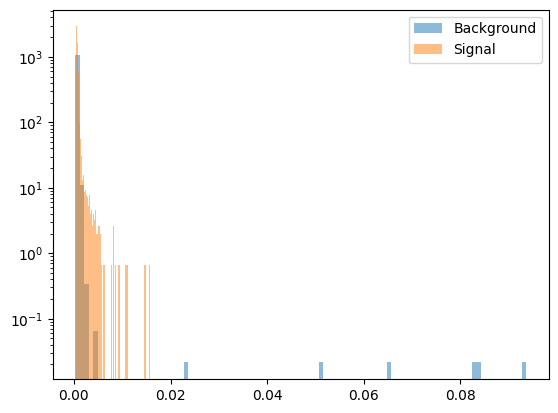

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_36.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


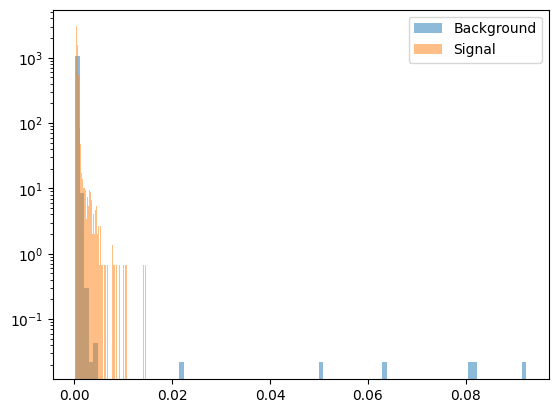

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_37.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


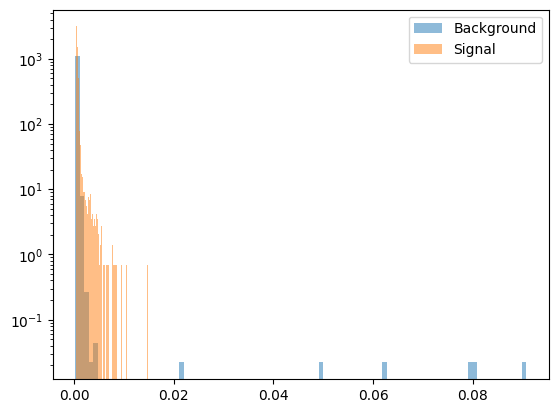

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_38.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


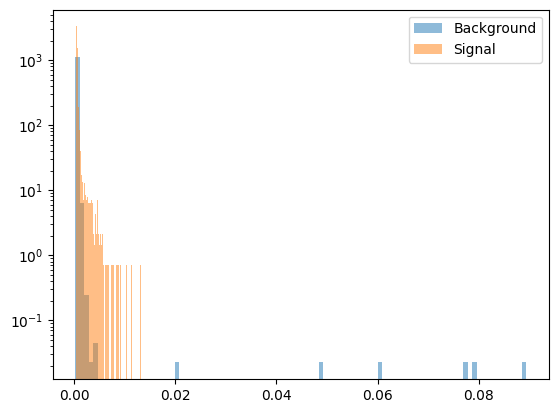

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_39.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


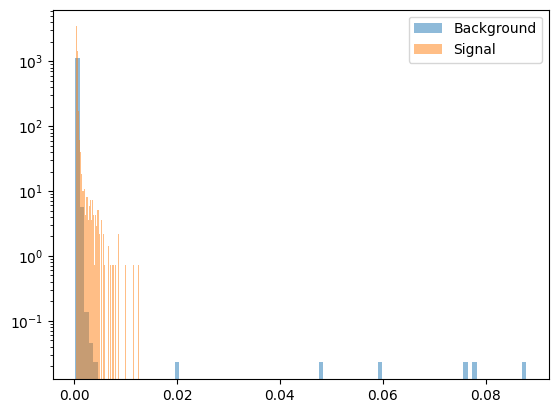

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_40.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


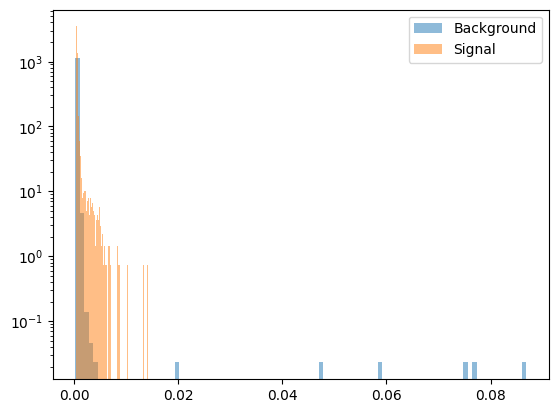

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_41.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


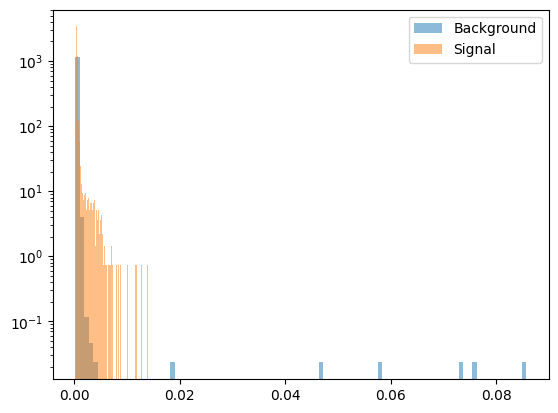

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_42.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


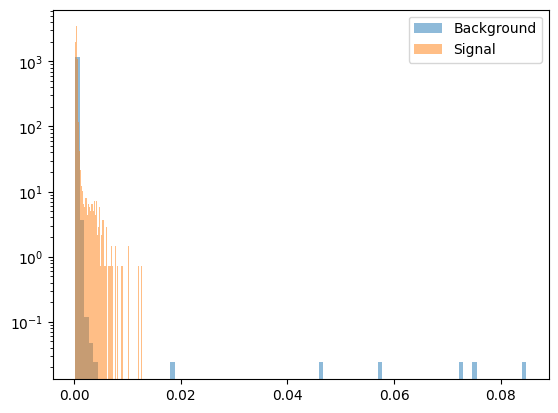

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_43.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


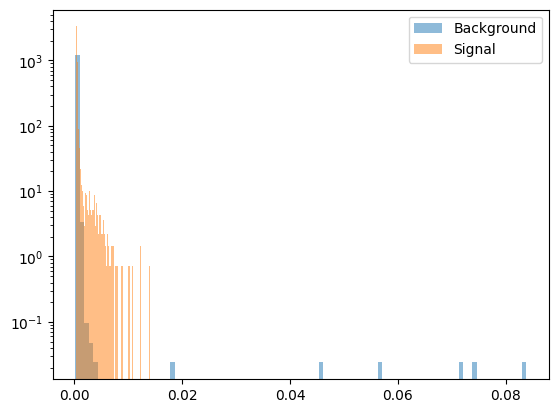

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_44.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


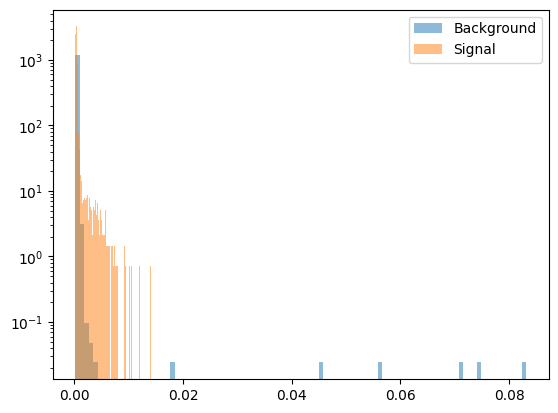

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_45.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


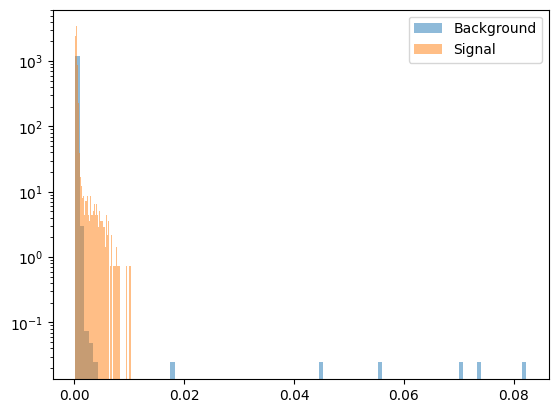

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_46.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


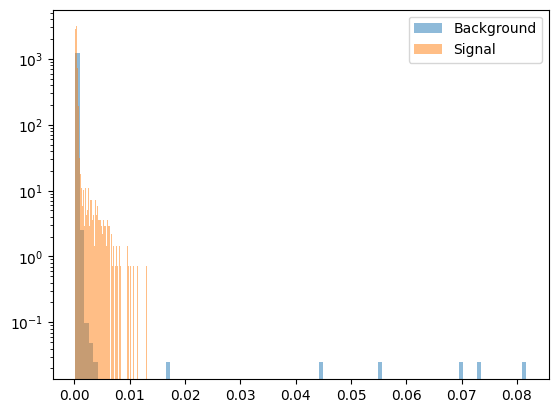

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_47.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


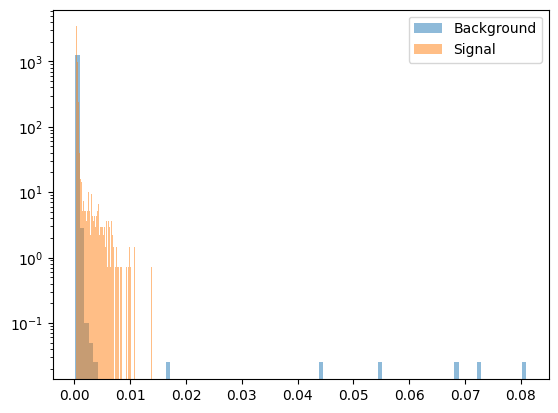

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_48.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


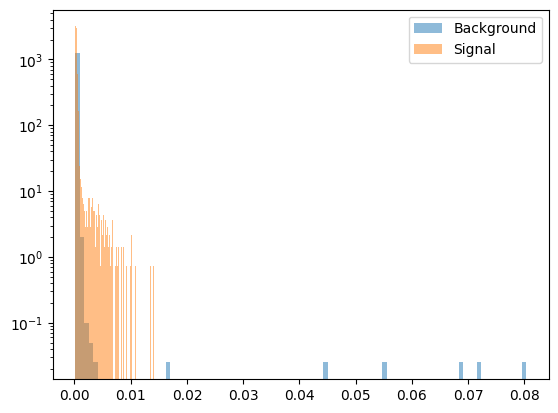

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_49.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


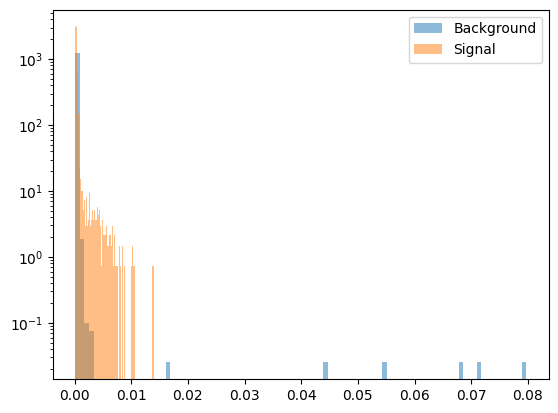

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_50.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


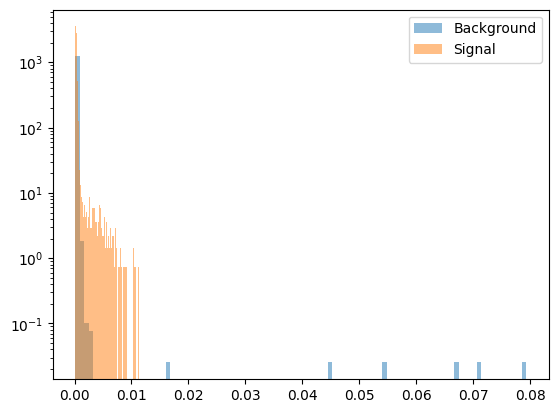

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_51.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


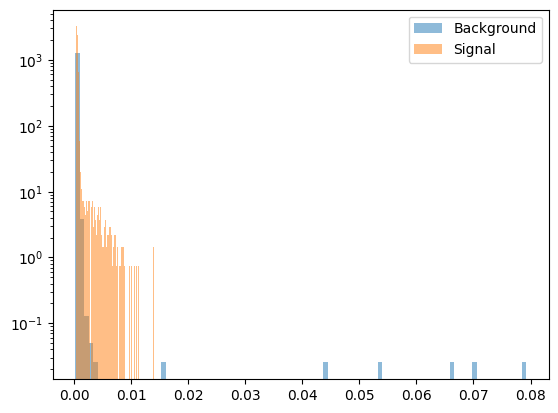

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_52.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


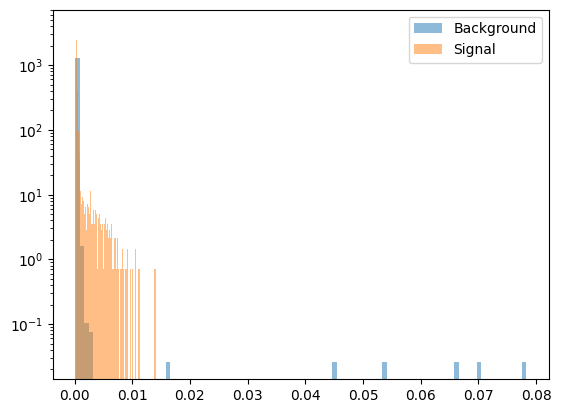

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_53.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


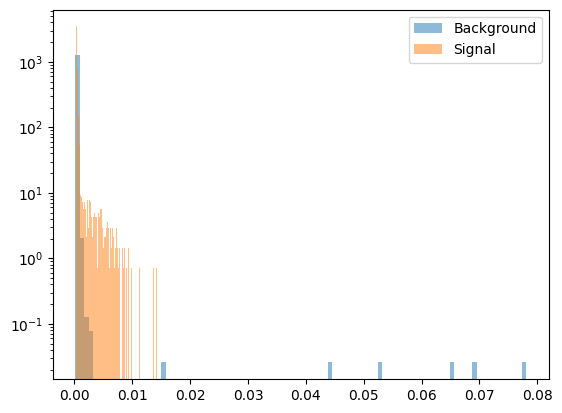

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_54.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


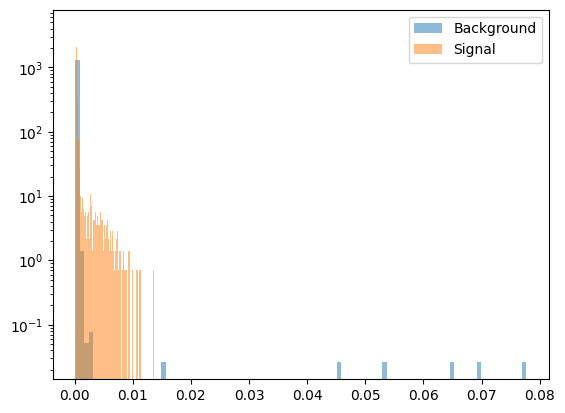

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_55.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


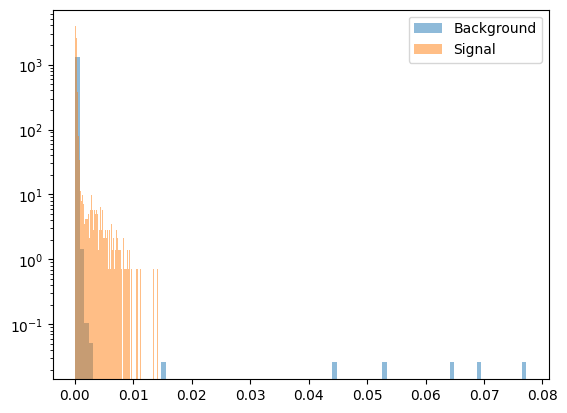

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_56.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


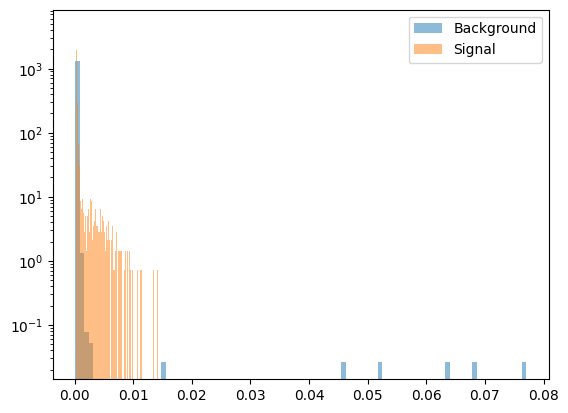

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_57.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


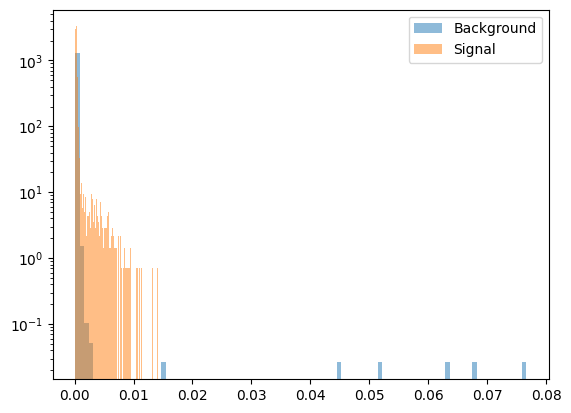

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_58.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


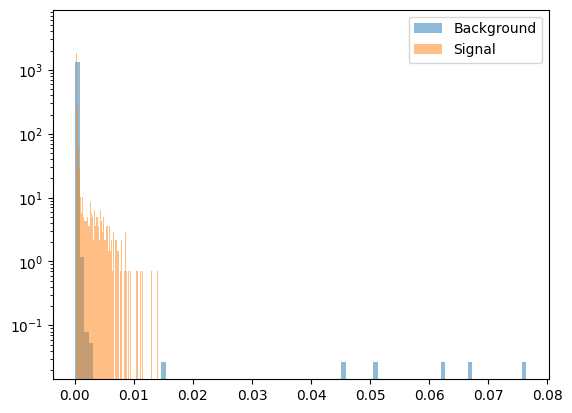

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_59.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


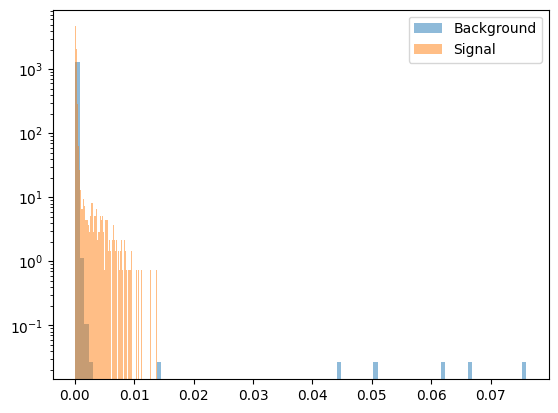

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_60.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


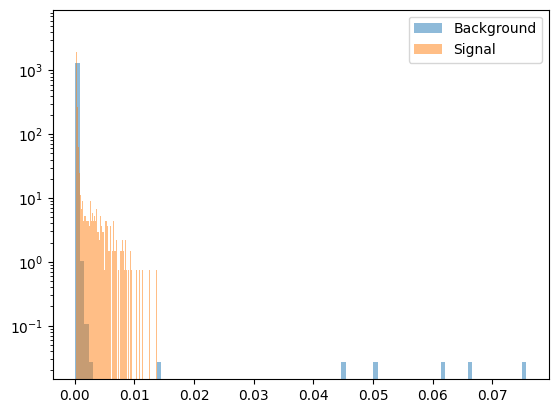

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_61.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


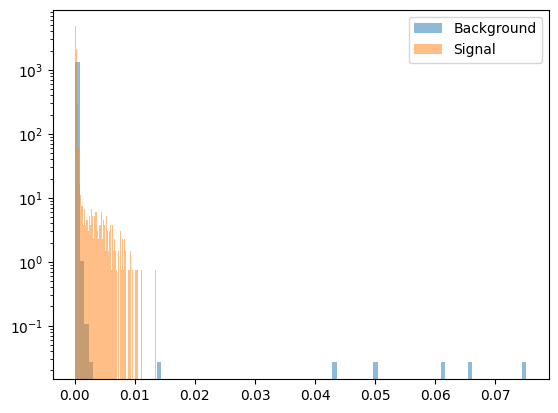

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_62.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


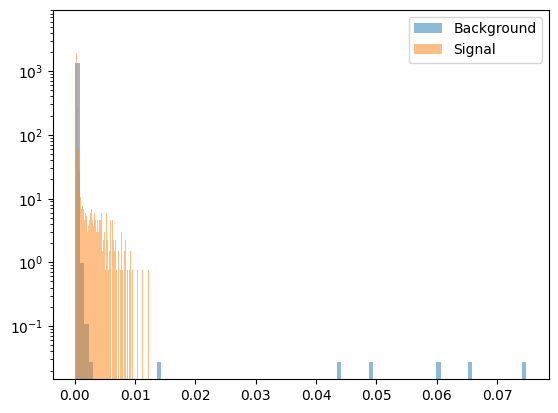

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_63.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


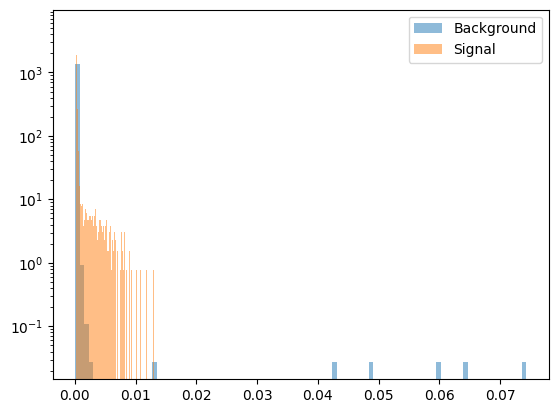

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_64.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


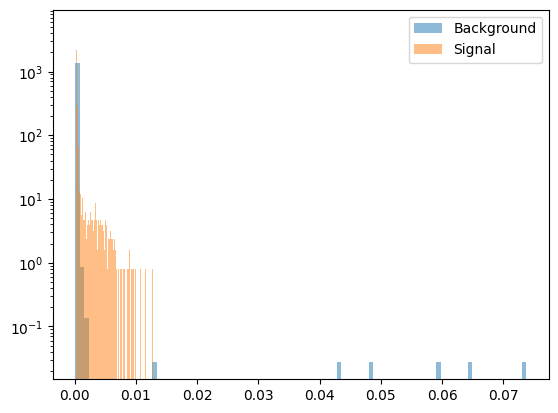

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_65.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


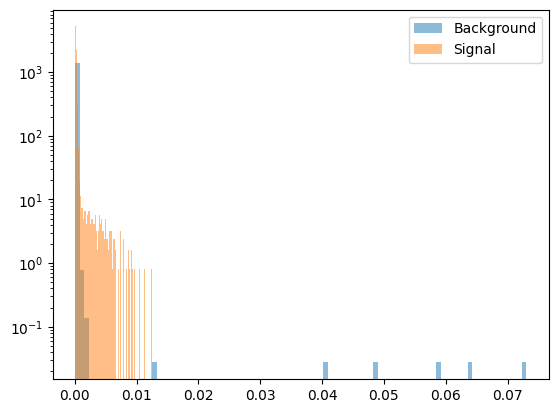

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_66.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


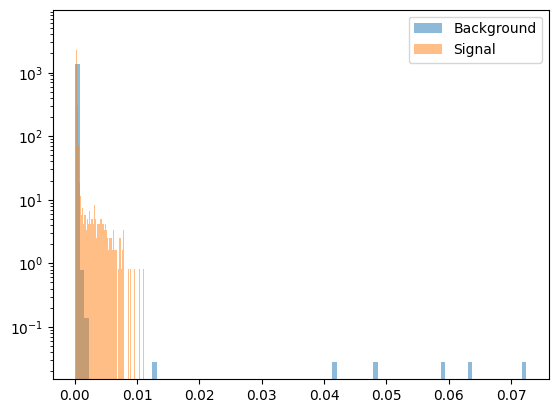

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_67.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


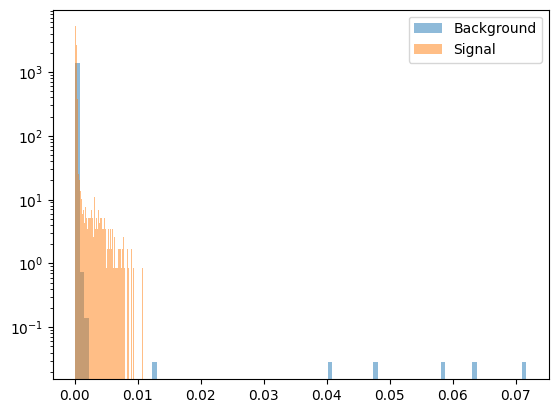

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_68.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


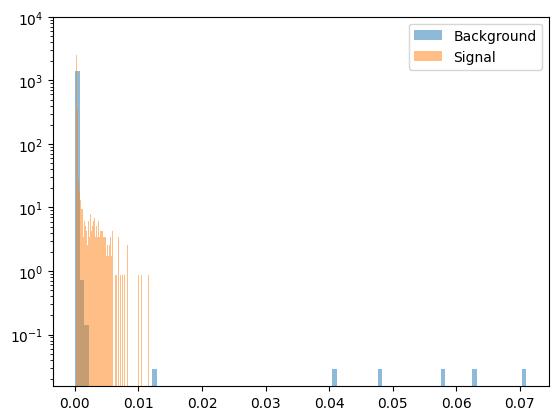

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_69.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


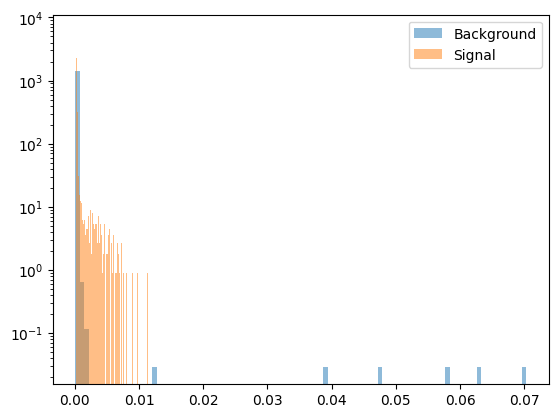

Evaluating model: /content/drive/My Drive/LIGO/DatasetSplitting/Datasplitting01/model_epochs/model_epoch_70.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


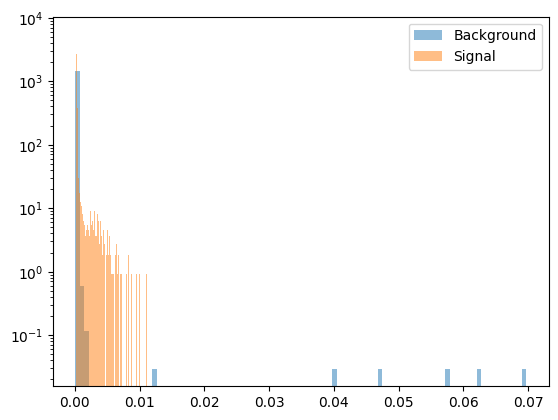

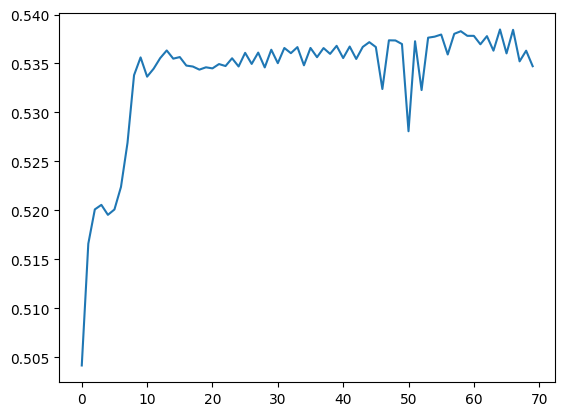

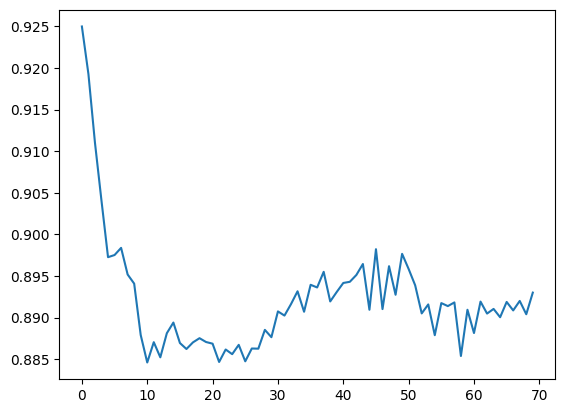

In [14]:
from sklearn.metrics import roc_curve, auc
def eval_test(model,background_test_data,signal_test_data):
  bg_test = model.predict(background_test_data)['transformer_output']
  sg_test = model.predict(signal_test_data)['transformer_output']
  mse_bg = np.mean((bg_test - background_test_data)**2, axis=(1,2))
  mse_sg = np.mean((sg_test - signal_test_data)**2, axis=(1,2))
  pred_val = np.concatenate((mse_sg, mse_bg))
  true_val = np.concatenate((np.ones(mse_sg.shape[0]), np.zeros(mse_bg.shape[0])))
  fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)
  AUC = auc(fpr_loss, tpr_loss)
  idx = np.argmin(np.abs(tpr_loss - 0.90))    #nearest value's index at 0.9 TPR
  desired_fpr = fpr_loss[idx]    #FPR at 0.9 TPR
  return AUC, desired_fpr, mse_bg, mse_sg

AUC_test=[]
FPR_test = []

for model_name in model_files[:70]:
    print(f"Evaluating model: {model_name}")
    model = load_model(model_name, custom_objects={"masked_mse_loss": masked_mse_loss,"TriangularCyclicalLearningRate": TriangularCyclicalLearningRate})
    AUC_, FPR_, mse_bg, mse_sg = eval_test(model,background_test_data,signal_test_data)
    plt.hist(mse_bg, density=True, bins=100, alpha=0.5, label='Background')
    plt.hist(mse_sg, density=True, bins=100, alpha=0.5, label='Signal')
    plt.semilogy()
    plt.legend()
    plt.show()
    AUC_test.append(AUC_)
    FPR_test.append(FPR_)
plt.plot(AUC_test)
plt.show()
plt.plot(FPR_test)
plt.show()

In [15]:
min(FPR_test),max(AUC_test)

(0.8846, 0.5384734579999999)